# Predicting Player Performance in Baseball using Hitting Data

**James Rouse**

**Introduction:**

This data science project revolves around predicting player performance for the 2023 baseball season. Focusing on individual player hitting data, our goal is to build predictive models that shed light on a player's potential contribution to scoring runs—the ultimate objective in baseball. The made up scenario is that a team is in desparate need of someone to bat in runs. They keep leaving runners on and need someone who will drive them in.

**The Target Variable:**
Runs Batted In (RBIs) serves as our key performance metric. It signifies a player's impact on their team's runs and reflects their ability to seize crucial moments during a game.

**Our Approach:**
The project spans data collection, preprocessing, exploratory data analysis (EDA), and model building. By parsing hitting data from the 2023 season, we'll extract key attributes, such as batting average, slugging percentage, home runs, and walks. 

**The Exploratory Journey:**
EDA will uncover relationships between RBIs and hitting metrics. We'll pinpoint influential factors and guide our feature selection for models.

**Building Predictive Models:**
Employing various machine learning algorithms as well as linear regression, we'll construct models to predict RBIs. Training, tuning, and evaluation will lead us to models capable of forecasting player performance.

In summary, this project seeks to predict player performance by decoding hitting data. RBIs will be our compass, offering insights to players, coaches, and enthusiasts seeking to understand the heart of baseball's dynamics. Join us in unraveling the nuances of baseball's essence through predictive analytics.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from pybaseball import batting_stats_range, team_batting
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import KFold
pd.options.mode.chained_assignment = None

**Data Collection:**
To start, we well fetch the data from pybaseball. pybaseball is a Python package that provides a convenient interface for accessing various baseball-related data, statistics, and information from online sources. The code below uses the function batting_stats_ragne from pybaseball, which creates a data frame called batting_data_df. This contains batting data for all MLB players this year. 

In [2]:
# Get the current year
current_year = datetime.now().year
today_date = datetime.now().date()
today_str = today_date.strftime('%Y-%m-%d')

# Calculate yesterday's date

# Fetch batting statistics for the current season up until yesterday
raw_data = batting_stats_range(start_dt=f'{current_year}-03-30', end_dt=today_str)

In [3]:
# Print the fetched data
batting_data_df = pd.DataFrame(raw_data)

batting_data_df.head()

Name  Age  #days     Lev          Tm    G   PA   AB    R    H  \
1          CJ Abrams   22      0  Maj-NL  Washington  141  566  519   77  127   
2  Jos\xc3\xa9 Abreu   36      0  Maj-AL     Houston  131  553  502   56  118   
3       Wilyer Abreu   24      2  Maj-AL      Boston   20   62   55    8   20   
4   Ronald Acuna Jr.   25      0  Maj-NL     Atlanta  149  694  606  138  205   
5       Willy Adames   27      0  Maj-NL   Milwaukee  139  598  520   68  111   

   ...  SH  SF  GDP  SB  CS     BA    OBP    SLG    OPS   mlbID  
1  ...   3   2    7  42   4  0.245  0.300  0.416  0.716  682928  
2  ...   0   6   14   0   1  0.235  0.295  0.371  0.665  547989  
3  ...   0   0    0   3   1  0.364  0.436  0.509  0.945  677800  
4  ...   0   3   15  66  13  0.338  0.418  0.596  1.014  660670  
5  ...   0   6   11   5   3  0.214  0.304  0.408  0.711  642715  

[5 rows x 28 columns]

**Data Cleaning: Ensuring Accurate Analysis**

In baseball data analysis, cleaning the data is essential to ensure accuracy and reliability. Baseball data often contains errors, missing values, and inconsistencies due to various data collection methods and sources. Cleaning the data removes inaccuracies, fixes missing values, and standardizes variables, allowing us to draw accurate conclusions and insights. Without clean data, our analyses could be skewed or misleading. Cleaning the data is vital for creating a solid foundation for meaningful and trustworthy analysis in the world of baseball statistics.

In [4]:
# Getting info about the columns in the dataframe
batting_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 1 to 678
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    653 non-null    object 
 1   Age     653 non-null    int64  
 2   #days   653 non-null    int64  
 3   Lev     653 non-null    object 
 4   Tm      653 non-null    object 
 5   G       653 non-null    int64  
 6   PA      653 non-null    int64  
 7   AB      653 non-null    int64  
 8   R       653 non-null    int64  
 9   H       653 non-null    int64  
 10  2B      653 non-null    int64  
 11  3B      653 non-null    int64  
 12  HR      653 non-null    int64  
 13  RBI     653 non-null    int64  
 14  BB      653 non-null    int64  
 15  IBB     653 non-null    int64  
 16  SO      653 non-null    int64  
 17  HBP     653 non-null    int64  
 18  SH      653 non-null    int64  
 19  SF      653 non-null    int64  
 20  GDP     653 non-null    int64  
 21  SB      653 non-null    int64  
 22  CS

It looks like there are 6 rows with missing values. Since only 6 out of the 609 rows are missing, these rows can just be dropped.

In [5]:
# Dropping NA values
batting_data_df = batting_data_df.dropna()

In [6]:
batting_data_df.duplicated().sum()

0

Because we are predicting RBI's, we can remove variables that won't be needed for the prediction. ID, days, name, as well as base running stats won't be necessary for calculating runs batted in. The ID and name are just labels and base running occurs after a batter is on base, where they can't obtain any RBI's.

In [7]:
# Dropping unecessary columns
columns_to_drop = ['mlbID', 'CS', 'SB', '#days', 'Name']
batting_data_df = batting_data_df.drop(columns=columns_to_drop)

In order for consistency, ease of access, and clarity, the variable names will be changed to snake case format 

In [8]:
# Creating a dictionary to map the data.
column_name_mapping = {
    'Age': 'age',
    'Lev': 'league',
    'Tm': 'team',
    'G': 'games',
    'PA': 'plate_appearances',
    'AB': 'at_bats',
    'R': 'runs',
    'H': 'hits',
    '2B': 'double',
    '3B': 'triple',
    'HR': 'home_run',
    'RBI': 'runs_batted_in',
    'BB': 'walk',
    'IBB': 'intentional_walk',
    'SO': 'strikeouts',
    'HBP': 'hit_by_pitch',
    'SH': 'sacrifice_hit',
    'SF': 'sacrifice_fly',
    'GDP': 'double_play',
    'BA': 'batting_average',
    'OBP': 'on_base_percentage',
    'SLG': 'slugging_percentage',
    'OPS': 'on_base_plus_slugging'
}

batting_data_df.rename(columns=column_name_mapping, inplace=True)

# Print the modified DataFrame
batting_data_df.columns

Index(['age', 'league', 'team', 'games', 'plate_appearances', 'at_bats',
       'runs', 'hits', 'double', 'triple', 'home_run', 'runs_batted_in',
       'walk', 'intentional_walk', 'strikeouts', 'hit_by_pitch',
       'sacrifice_hit', 'sacrifice_fly', 'double_play', 'batting_average',
       'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging'],
      dtype='object')

Investigating the teams column, as it is of type object in order to see what it contains. While investigating, it looked like some players had multiple teams separated by a comma. It looks like only 6% of players have played for multiple teams and later on in the project, we will join a table by team name, so these players will just be dropped.

In [9]:
# Inspecting the unique values of the 'team' column
batting_data_df['team'].unique()

array(['Washington', 'Houston', 'Boston', 'Atlanta', 'Milwaukee',
       'Los Angeles', 'Oakland', 'Arizona', 'Chicago', 'Boston,Colorado',
       'New York', 'Miami', 'Pittsburgh', 'Tampa Bay', 'St. Louis',
       'Cleveland', 'San Diego', 'Detroit', 'Cincinnati,New York',
       'San Francisco', 'Cincinnati', 'Kansas City,San Francisco',
       'Cleveland,Miami', 'Toronto', 'Baltimore', 'Colorado',
       'Kansas City', 'Philadelphia', 'Chicago,Miami', 'Minnesota',
       'Seattle', 'Chicago,Washington', 'Milwaukee,New York',
       'Arizona,Seattle', 'Texas', 'Philadelphia,Pittsburgh',
       'Pittsburgh,San Diego', 'Miami,San Diego', 'Colorado,Los Angeles',
       'San Francisco,St. Louis,Toronto', 'Detroit,San Francisco',
       'Los Angeles,New York', 'Cleveland,Detroit', 'Pittsburgh,Texas',
       'Pittsburgh,Toronto', 'Boston,Los Angeles', 'Baltimore,New York',
       'Arizona,Detroit', 'Cleveland,Oakland', 'Atlanta,Kansas City',
       'Minnesota,Toronto', 'Chicago,Detroit,Los

In [10]:
# Determining how many values in the 'team' column have multiple teams
count_with_comma = batting_data_df[batting_data_df['team'].str.contains(',')].shape[0]

# Count the total number of players
total_players = batting_data_df.shape[0]

# Calculate the proportion
proportion_with_comma = (count_with_comma / total_players) * 100
print(f"Proportion of players with comma in team name (traded players): {proportion_with_comma:.2f}%")


Proportion of players with comma in team name (traded players): 7.72%


In [11]:
# Get value counts of all teams
batting_data_df['team'].value_counts()

Los Angeles           42
New York              41
Chicago               40
Cincinnati            24
San Francisco         24
                      ..
Boston,Los Angeles     1
Baltimore,New York     1
Arizona,Detroit        1
Cleveland,Oakland      1
Arizona,Chicago        1
Name: team, Length: 71, dtype: int64

As stated earlier, it looks like the data contains players who belong to multiple teams. These are likely players who have likely been traded. Because there is a small proportion of player who have been traded, these players will just be ommitted from the data.

In [12]:
# Removing data where the team has a comma.
batting_data_df = batting_data_df[~batting_data_df['team'].str.contains('[,]')]
batting_data_df['team'].unique()

array(['Washington', 'Houston', 'Boston', 'Atlanta', 'Milwaukee',
       'Los Angeles', 'Oakland', 'Arizona', 'Chicago', 'New York',
       'Miami', 'Pittsburgh', 'Tampa Bay', 'St. Louis', 'Cleveland',
       'San Diego', 'Detroit', 'San Francisco', 'Cincinnati', 'Toronto',
       'Baltimore', 'Colorado', 'Kansas City', 'Philadelphia',
       'Minnesota', 'Seattle', 'Texas'], dtype=object)

It is also clear that there is no differentiation between teams in the same city. To fix this, we will need to check the league column to see which team the player is actually on to fix this error. For example, if a team is in New York, but in the American League, we will set the team name to New York Yankees insstead of just New York

In [13]:
# Correcting team names for cities with multiple teams
conditions = [
    (batting_data_df['team'] == 'New York') & (batting_data_df['league'] == 'Maj-AL'),
    (batting_data_df['team'] == 'New York') & (batting_data_df['league'] == 'Maj-NL'),
    (batting_data_df['team'] == 'Los Angeles') & (batting_data_df['league'] == 'Maj-NL'),
    (batting_data_df['team'] == 'Los Angeles') & (batting_data_df['league'] == 'Maj-AL'),
    (batting_data_df['team'] == 'Chicago') & (batting_data_df['league'] == 'Maj-NL'),
    (batting_data_df['team'] == 'Chicago') & (batting_data_df['league'] == 'Maj-AL')
]

choices = ['New York Yankees', 'New York Mets', 'Los Angeles Dodgers', 'Los Angeles Angels', 'Chicago Cubs', 'Chicago White Sox']

batting_data_df['team'] = np.select(conditions, choices, default=batting_data_df['team'])
batting_data_df.head()

age  league        team  games  plate_appearances  at_bats  runs  hits  \
1   22  Maj-NL  Washington    141                566      519    77   127   
2   36  Maj-AL     Houston    131                553      502    56   118   
3   24  Maj-AL      Boston     20                 62       55     8    20   
4   25  Maj-NL     Atlanta    149                694      606   138   205   
5   27  Maj-NL   Milwaukee    139                598      520    68   111   

   double  triple  ...  intentional_walk  strikeouts  hit_by_pitch  \
1      23       6  ...                 2         112            13   
2      20       0  ...                 1         120             5   
3       5       0  ...                 0          16             0   
4      33       3  ...                 3          78             7   
5      25       2  ...                 1         152             6   

   sacrifice_hit  sacrifice_fly  double_play  batting_average  \
1              3              2            7            0.245   
2              0              6           14            0.235   
3              0              0            0            0.364   
4              0              3           15            0.338   
5              0              6           11            0.214   

   on_base_percentage  slugging_percentage  on_base_plus_slugging  
1               0.300                0.416                  0.716  
2               0.295                0.371                  0.665  
3               0.436                0.509                  0.945  
4               0.418                0.596                  1.014  
5               0.304                0.408                  0.711  

[5 rows x 23 columns]

Implementing a threshold for minimum plate appearances to filter out players with limited or insufficient data.

In [14]:
# Setting a threshold for minimum plate appearance
batting_data_df = batting_data_df[batting_data_df['plate_appearances'] >= 150]

**Exploratory Data Analysis**

Graphs depicting the correlations of runs batted in will be generated, aiming to explore their associations with various factors such as age, team affiliation, and total hits are constructed

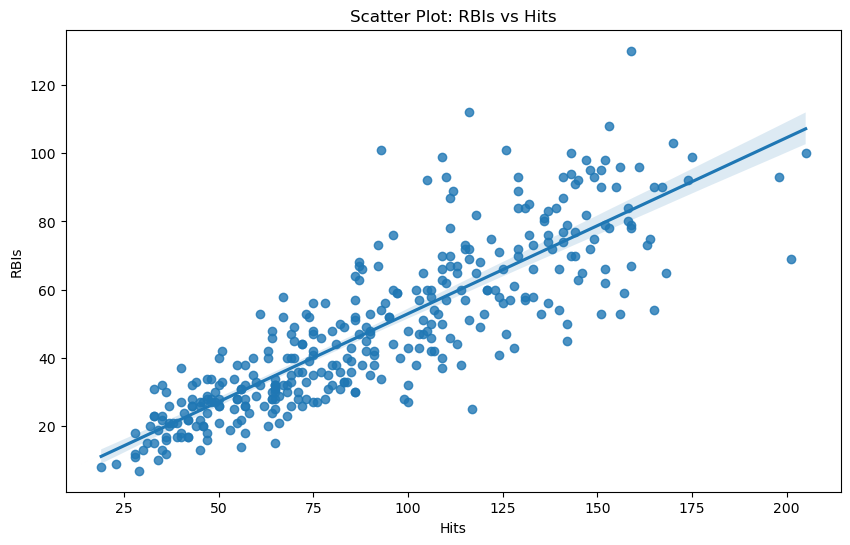

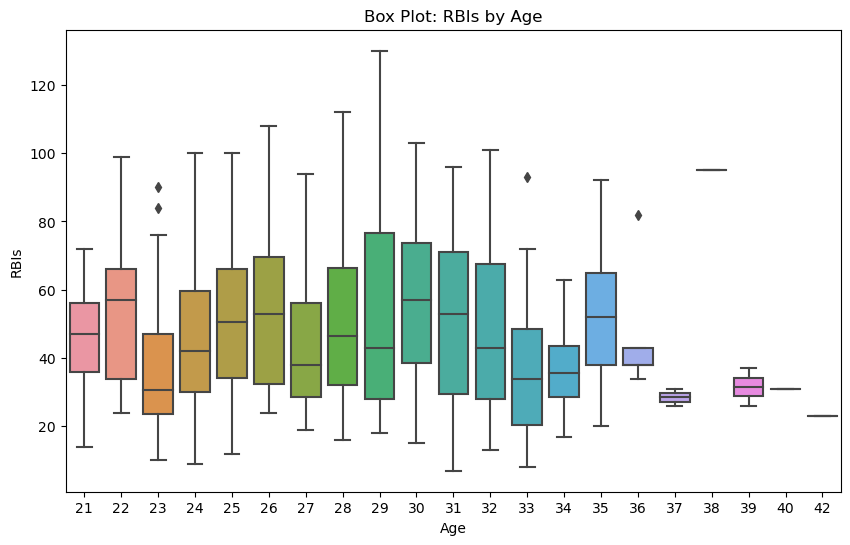

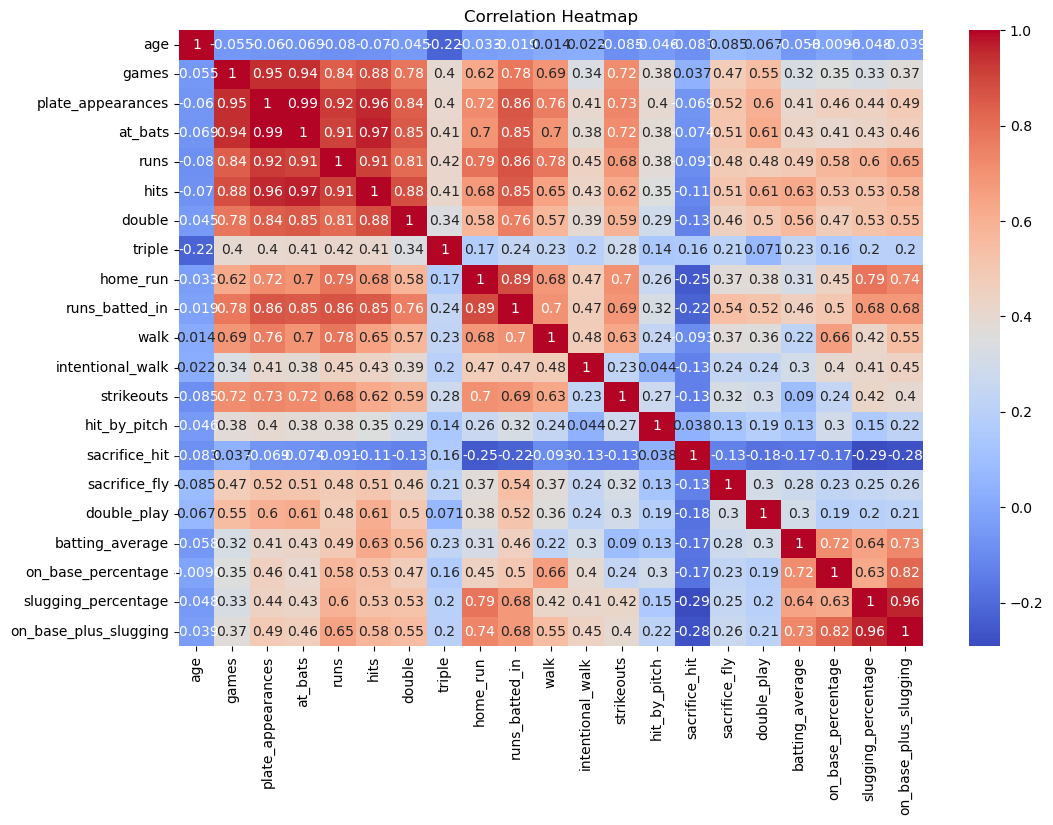

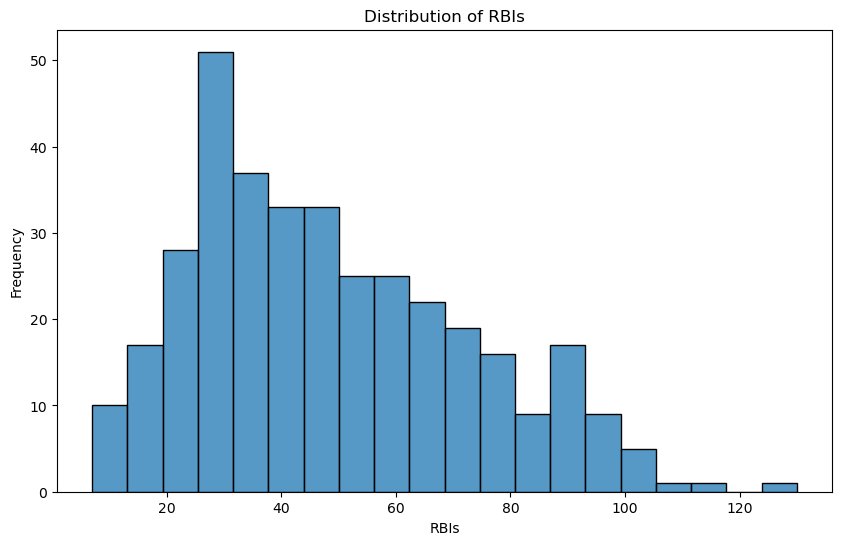

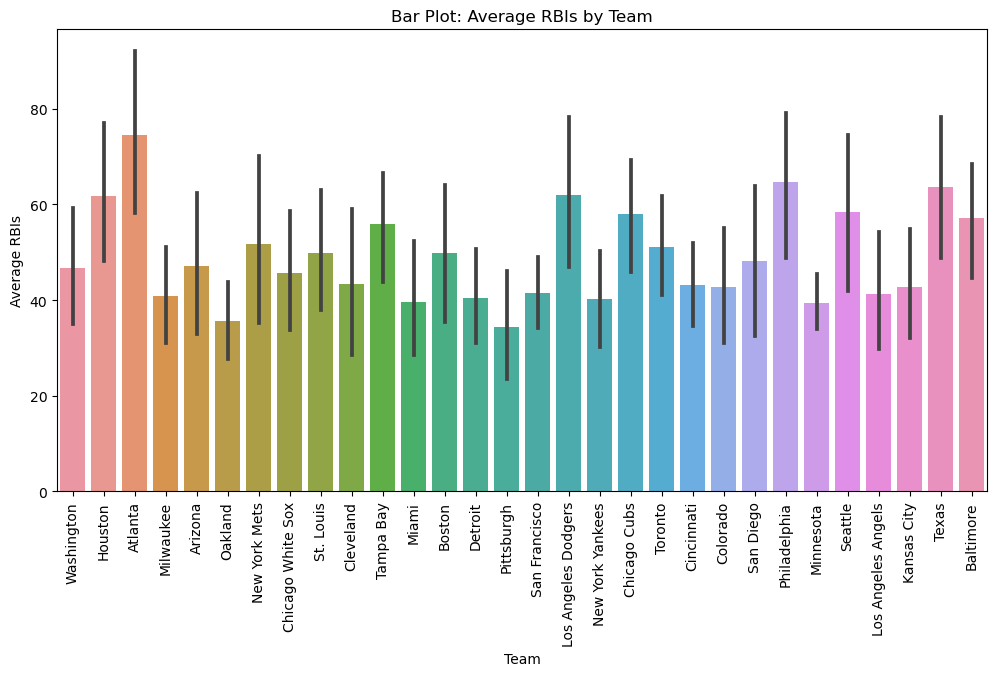

In [15]:
# Scatter plot: RBI vs Hits
plt.figure(figsize=(10, 6))
sns.regplot(data=batting_data_df, x='hits', y='runs_batted_in')
plt.xlabel('Hits')
plt.ylabel('RBIs')
plt.title('Scatter Plot: RBIs vs Hits')
plt.show()

# Box plot: RBIs by Age
plt.figure(figsize=(10, 6))
sns.boxplot(data=batting_data_df, x='age', y='runs_batted_in')
plt.xlabel('Age')
plt.ylabel('RBIs')
plt.title('Box Plot: RBIs by Age')
plt.show()

# Correlation heatmap
correlation_matrix = batting_data_df.corr(numeric_only = True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Histogram: Distribution of RBIs
plt.figure(figsize=(10, 6))
sns.histplot(data=batting_data_df, x='runs_batted_in', bins=20)
plt.xlabel('RBIs')
plt.ylabel('Frequency')
plt.title('Distribution of RBIs')
plt.show()

# Bar plot: RBIs by Team
plt.figure(figsize=(12, 6))
sns.barplot(data=batting_data_df, x='team', y='runs_batted_in')
plt.xlabel('Team')
plt.ylabel('Average RBIs')
plt.title('Bar Plot: Average RBIs by Team')
plt.xticks(rotation=90)
plt.show()


In the exploration of the relationship between Runs Batted In (RBIs) and Hits, a notable trend emerges, suggesting a positive correlation between these two variables. As the number of hits increases, players tend to achieve higher RBIs, indicating a connection between their ability to connect with the ball and their effectiveness in driving runs. However, while this positive correlation is apparent, it's essential to consider the distribution of RBIs. A slight right skewness is observed in the distribution, implying that there are more players with fewer RBIs and relatively fewer players with higher RBIs. This skewness may potentially be mitigated through the removal of outliers, which could influence the distribution's shape.

Furthermore, our analysis of the relationship between age and RBIs indicates a lack of a clear trend between the two variables. Age does not seem to be a significant predictor of RBIs, suggesting that a player's effectiveness in driving runs may not be solely influenced by their age. This observation underscores the complex interplay of various factors contributing to a player's performance in this aspect of the game. 

Being on different teams seems to have an impact on a player's total RBI stats, in order to account for this, this variable will either be dummy-encoded, or another dataframe with team stats will be merged and feature engineering will take place. 

When looking at the heatmap, one thing stands out: how much a player's Runs Batted In (RBIs) depends on how many games they've played and their plate appearances. There's another interesting thing we see—a strong link between RBIs and strikeouts. It might seem strange, but it's not as complicated as it looks. When a player has more chances at bat (plate appearances), they tend to get more RBIs and more strikeouts, which makes these two numbers appear connected.

However, we need to think if a player striking out a lot really means they're being super productive. This is where "normalization" comes in. It's a way to make the numbers fair and balanced. By dividing each statistic by plate appearances, we're making things even. This way, teams can get a better idea of what to expect from a player every time they go up to bat. It's like seeing how effective they are in each turn.

This new way of looking at things helps us understand the true impact of a player's performance. It evens the playing field, making sure we don't just focus on the number of games a player has been in. It's a smarter way to judge how well they're really doing. In baseball, numbers can tell us a lot, but it's important to look at them the right way to get the real story.

**Correlation Insights: Cumulative Stats and RBIs**

Upon inspecting the heatmap of correlations, a notable pattern emerges between RBIs and cumulative statistics, including strikeouts. This relationship stems from the inherent connection between cumulative stats and the number of opportunities for RBIs. Players with more at-bats tend to accumulate more RBIs, a logical outcome considering the increased chances to drive in runs.

However, the presence of high RBIs correlated with higher strikeouts also underscores the nuanced nature of this relationship. While accumulating RBIs is a positive indicator of offensive contributions, an increased frequency of strikeouts may not be as desirable. Striking out is often associated with missed scoring opportunities, highlighting the balance between power hitting and plate discipline.

To ensure a fair assessment of player performance, it becomes imperative to normalize these statistics per at-bat. This approach levels the playing field, allowing us to evaluate how efficiently a player generates RBIs relative to their plate appearances. By normalizing per at-bat, we mitigate the influence of sheer volume and gain a more accurate perspective on a player's RBI efficiency, unearthing the true impact of their offensive prowess.

In [16]:
# Inspecting the columns of the data frame
batting_data_df.columns

Index(['age', 'league', 'team', 'games', 'plate_appearances', 'at_bats',
       'runs', 'hits', 'double', 'triple', 'home_run', 'runs_batted_in',
       'walk', 'intentional_walk', 'strikeouts', 'hit_by_pitch',
       'sacrifice_hit', 'sacrifice_fly', 'double_play', 'batting_average',
       'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging'],
      dtype='object')

In [17]:
# Normalizing variables
variables_to_normalize = ['hits', 'double', 'triple', 'home_run', 'runs_batted_in', 
                          'walk', 'intentional_walk', 'strikeouts', 'hit_by_pitch',
                          'sacrifice_hit', 'sacrifice_fly', 'double_play']

# Iterate through the variables and add normalized columns, then drop the original columns
for var in variables_to_normalize:
    normalized_col_name = f'{var}_per_pa'
    batting_data_df[normalized_col_name] = batting_data_df[var] / batting_data_df['plate_appearances']
    batting_data_df.drop(columns=[var], inplace=True)

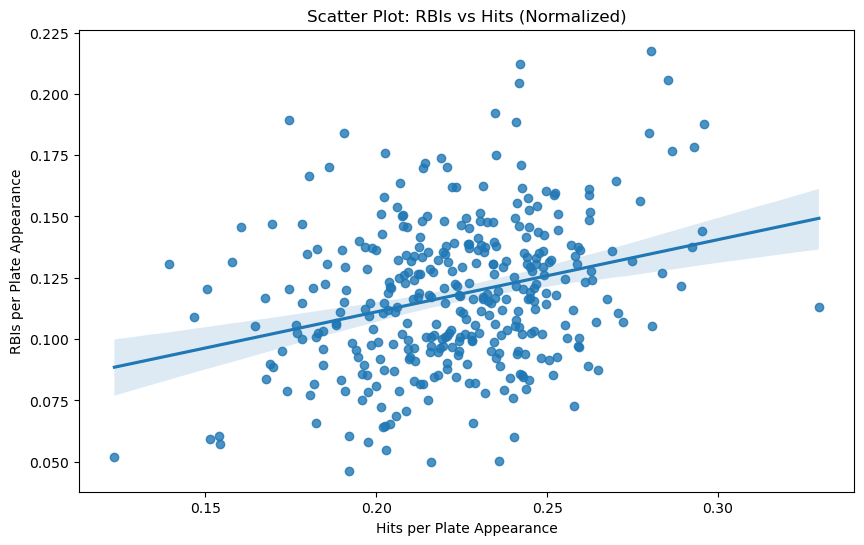

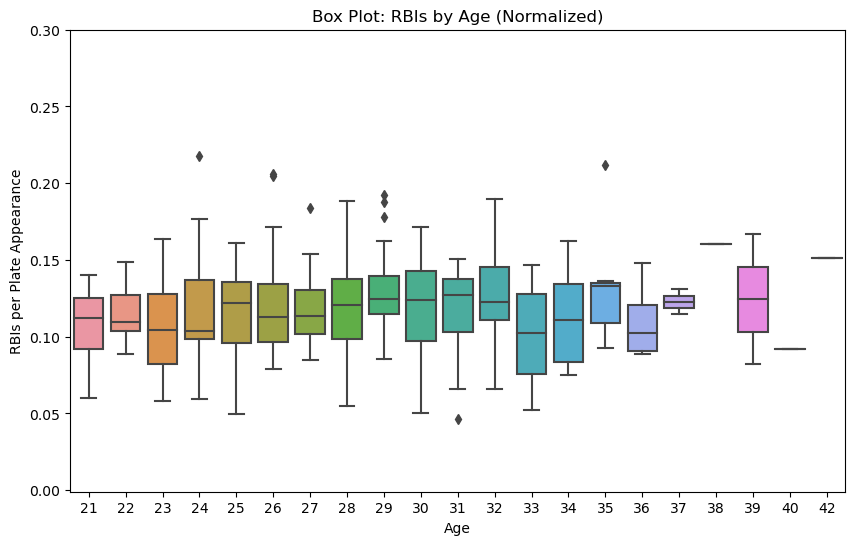

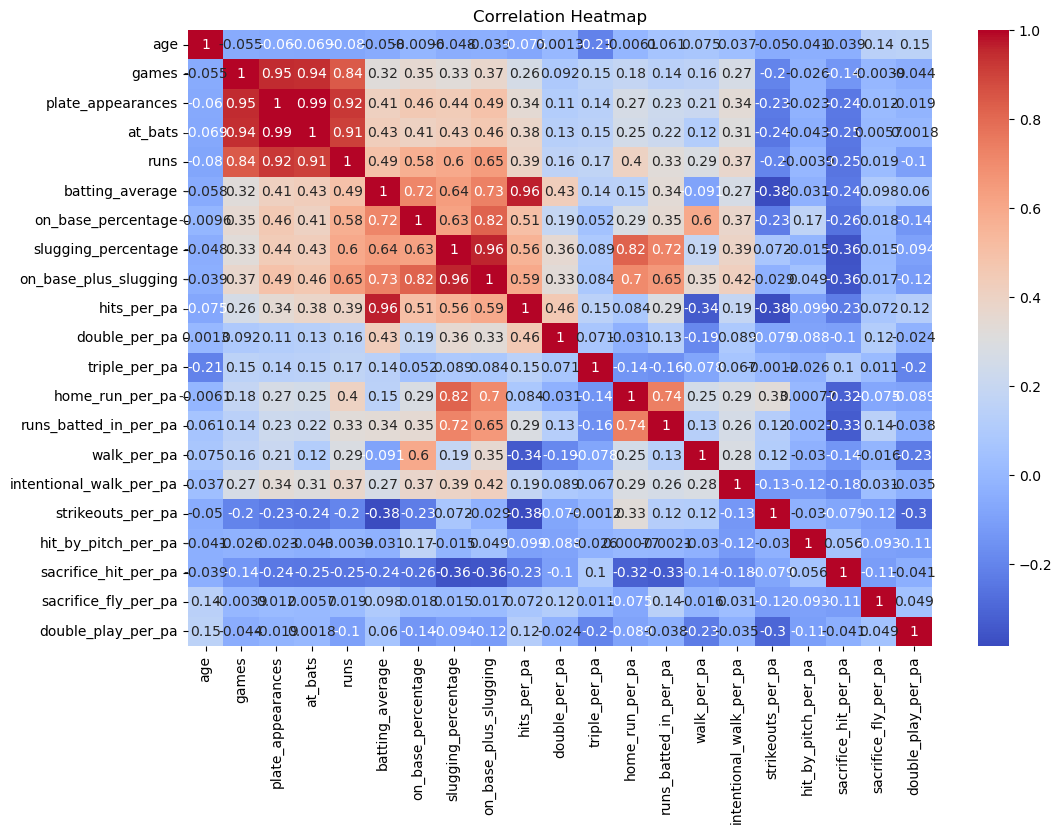

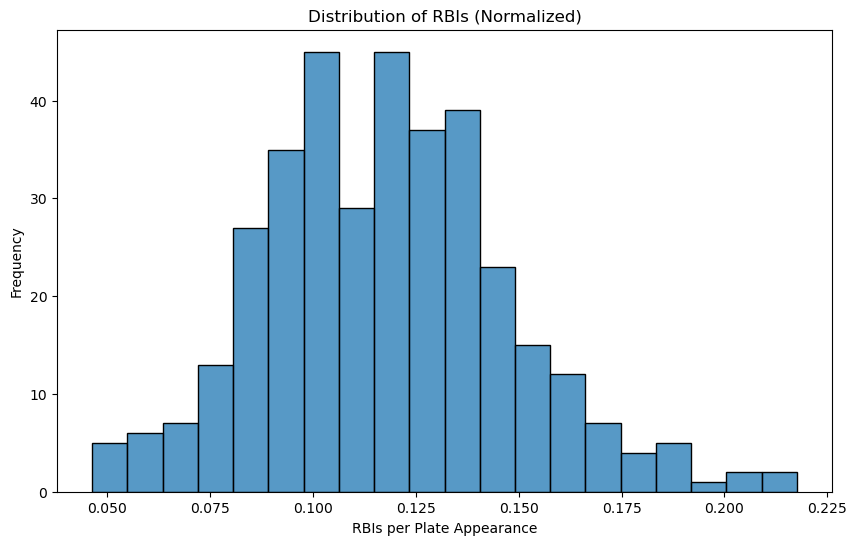

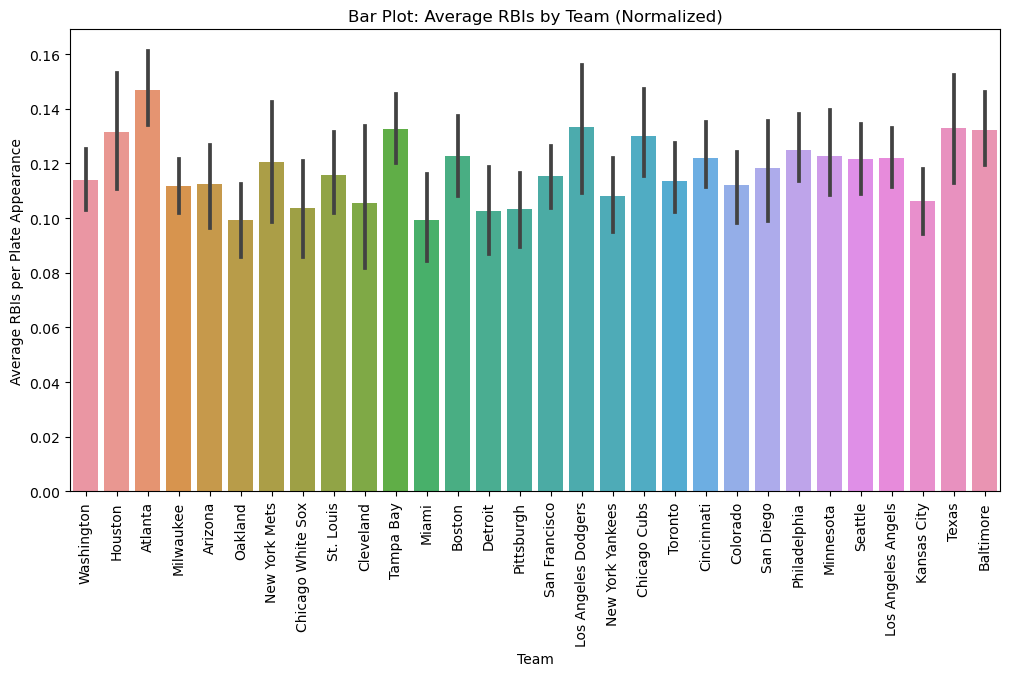

In [18]:
# Scatter plot: RBI vs Hits
plt.figure(figsize=(10, 6))
sns.regplot(data=batting_data_df, x='hits_per_pa', y='runs_batted_in_per_pa')
plt.xlabel('Hits per Plate Appearance')
plt.ylabel('RBIs per Plate Appearance')
plt.title('Scatter Plot: RBIs vs Hits (Normalized)')
plt.show()

# Box plot: RBIs by Age
plt.figure(figsize=(10, 6))
sns.boxplot(data=batting_data_df, x='age', y='runs_batted_in_per_pa')
plt.xlabel('Age')
plt.ylabel('RBIs per Plate Appearance')
plt.title('Box Plot: RBIs by Age (Normalized)')
plt.ylim(-.001, 0.3)  # Set y-axis limit to 0.3
plt.show()

# Correlation heatmap
correlation_matrix = batting_data_df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Histogram: Distribution of RBIs
plt.figure(figsize=(10, 6))
sns.histplot(data=batting_data_df, x='runs_batted_in_per_pa', bins=20)
plt.xlabel('RBIs per Plate Appearance')
plt.ylabel('Frequency')
plt.title('Distribution of RBIs (Normalized)')
plt.show()

# Bar plot: RBIs by Team
plt.figure(figsize=(12, 6))
sns.barplot(data=batting_data_df, x='team', y='runs_batted_in_per_pa')
plt.xlabel('Team')
plt.ylabel('Average RBIs per Plate Appearance')
plt.title('Bar Plot: Average RBIs by Team (Normalized)')
plt.xticks(rotation=90)
plt.show()

When we took a closer look at the data and decided to normalize the variables by plate appearance, something interesting happened. The connections between most variables and Runs Batted In (RBIs) became less strong. This might seem a bit surprising, but there's a simple reason behind it.

Normalizing the variables by plate appearance means that we're looking at things "per turn at bat." By doing this, we're considering the player's performance in relation to the opportunities they have to hit. Before normalization, players with more plate appearances tended to have both more RBIs and more of other stats like hits, walks, and strikeouts. This made these numbers seem more connected than they actually were.

However, when we normalize, the playing field levels out. We're now comparing players on a more equal basis. Some players might have fewer plate appearances, but their performance in each turn is what matters. This way, the impact of the player's performance is clearer, without the skew from different numbers of plate appearances.

Interestingly, as we investigated further, we found that the distribution of RBIs (now per plate appearance) started to look more normal. In other words, it began to resemble a more balanced and symmetric shape. This suggests that when we take plate appearances into account, the RBIs per plate appearance align more closely with what we'd expect in a typical distribution.

In summary, by normalizing the variables by plate appearance, we've eliminated the influence of the number of plate appearances and focused on each player's efficiency in hitting. This provides a more accurate assessment of how well players are doing and brings RBIs per plate appearance closer to a normal distribution, making our analysis more robust and insightful.

As we prepare to build models, we want to make sure that we are selecting the right features to include in the model. To get a better understanding of how each feature relates to the target variable, each variable will be plotted with the target variable using a regression plot.

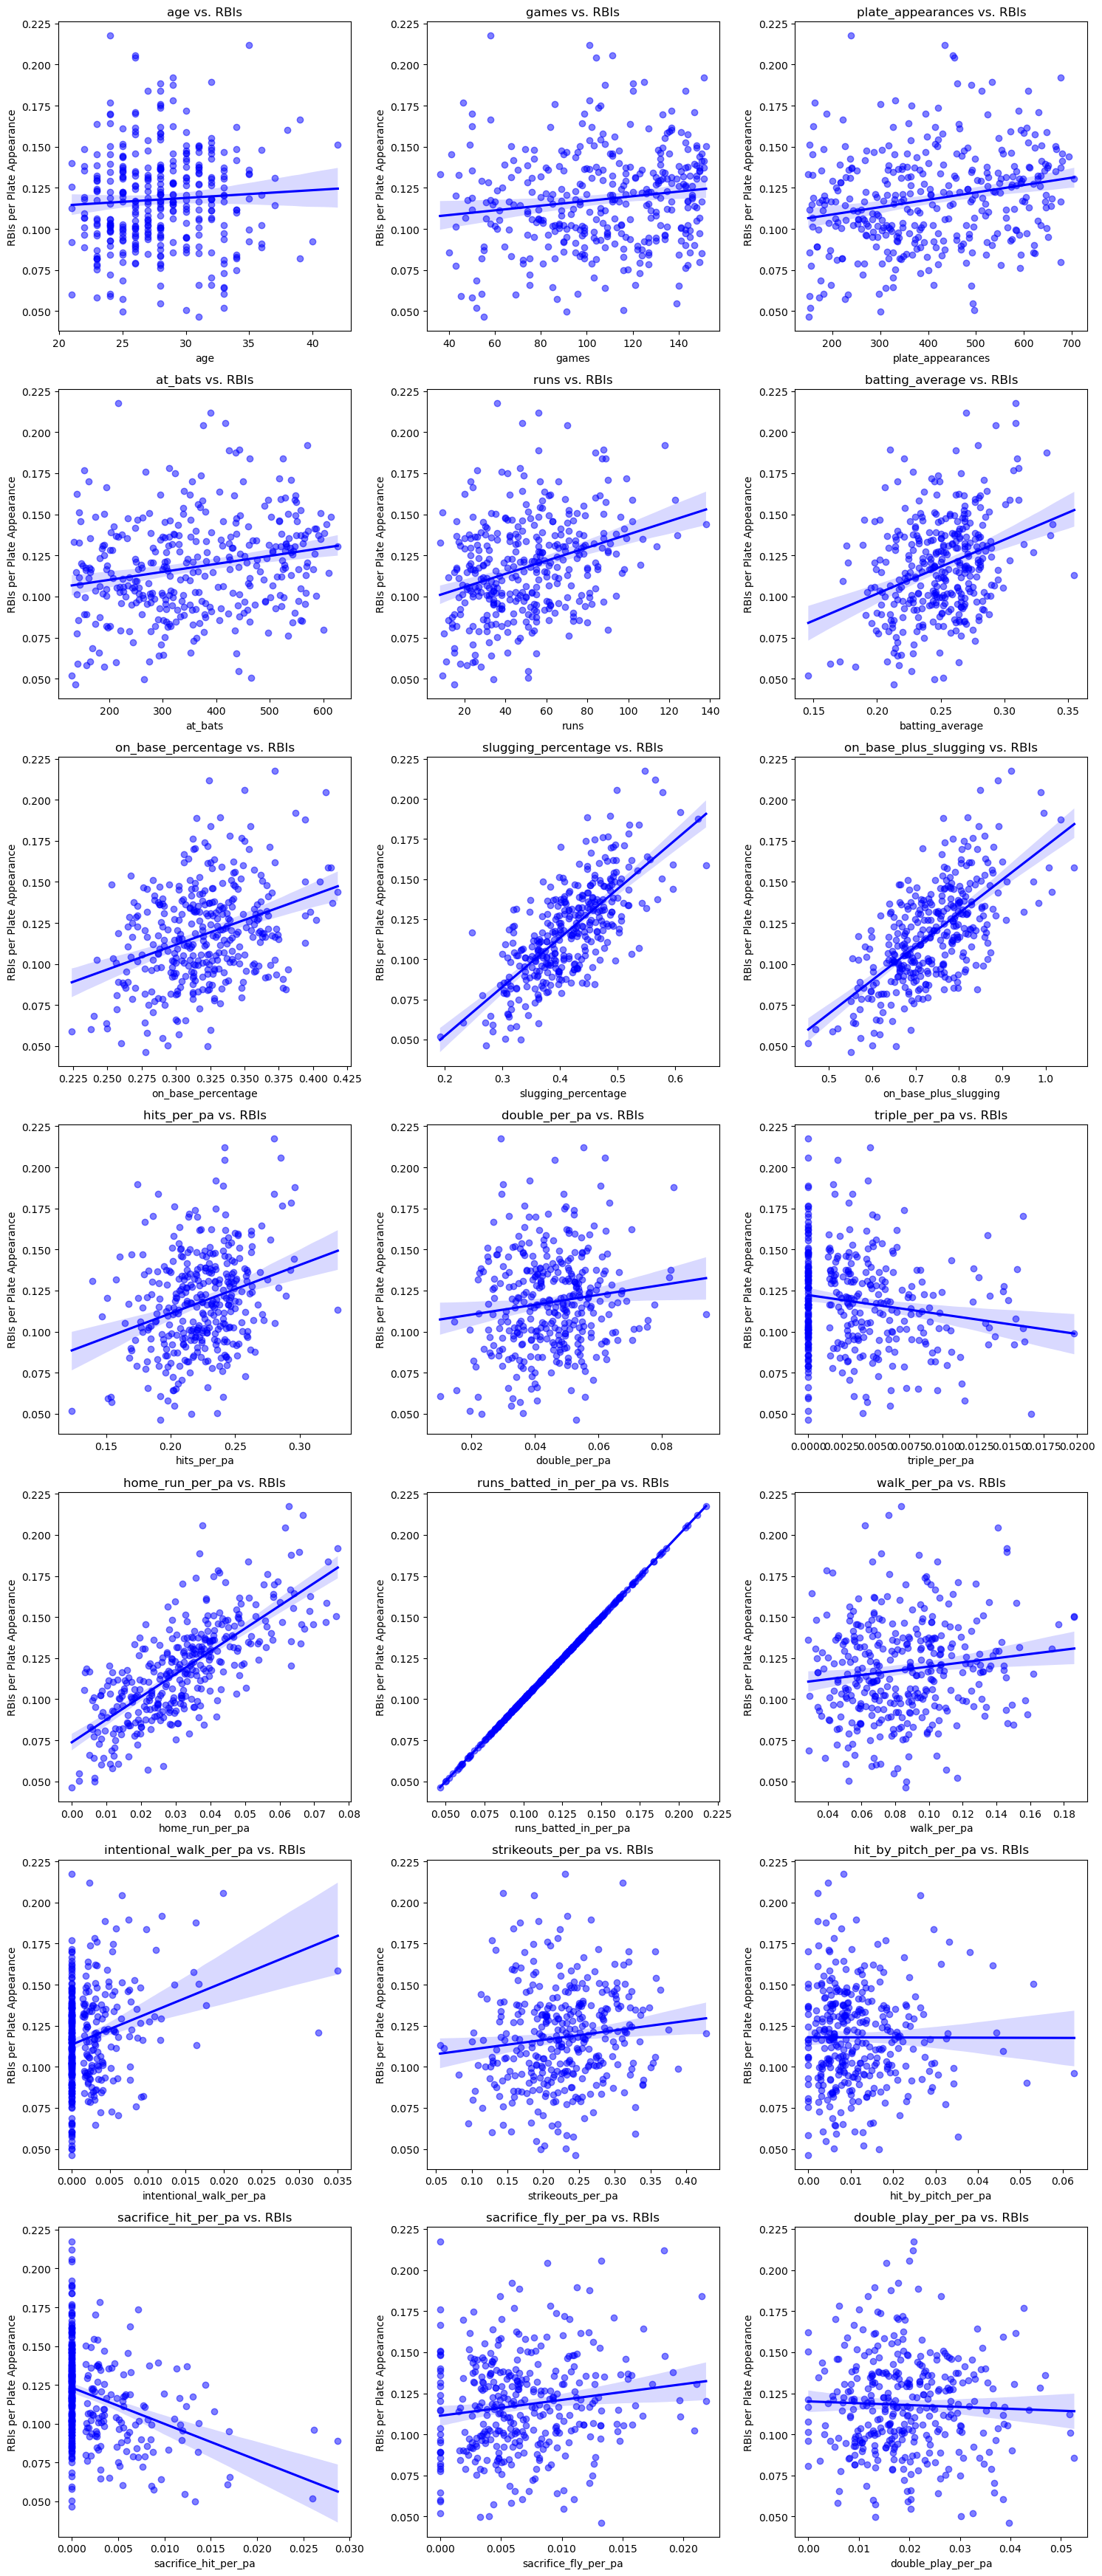

In [19]:
# Get the list of numeric column names
numeric_column_names = batting_data_df.select_dtypes(include='number').columns.tolist()

# Create subplots for each numeric column
num_rows = (len(numeric_column_names) + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

# Create scatter plots with regression lines for numeric columns
for i, var in enumerate(numeric_column_names):
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    sns.regplot(data=batting_data_df, x=var, y='runs_batted_in_per_pa', ax=ax, color='blue', scatter_kws={'alpha': 0.5})
    ax.set_xlabel(var)
    ax.set_ylabel('RBIs per Plate Appearance')
    ax.set_title(f'{var} vs. RBIs')

# Adjust layout
plt.tight_layout()
plt.show()


The variables 'runs,' 'batting average,' 'slugging percentage,' 'on-base percentage,' 'double per plate appearance,' 'triple per plate appearance,' 'hits per plate appearance,' 'home run per plate appearance,' and 'walk per plate appearance' have demonstrated the strongest linear associations with the target variable 'RBIs per plate appearance' in our analysis. Given their pronounced relationships with the dependent variable, these variables have been selected to be included in our regression model. By incorporating these key variables, we aim to capture the significant contributing factors that influence the 'RBIs per plate appearance' outcome. This careful selection ensures that our model will provide meaningful insights and accurate predictions regarding the relationship between these specific variables and the target variable of interest.

Outliers for the target are removed prior to our regression analysis. Outliers are extreme data points that can mess up the results and make the model less accurate. Removing them helps the model work better. Outliers can make the line that the model draws not quite right, affecting the slope and where the line crosses the y-axis. This messes up the numbers the model uses to make predictions. Taking out the outliers makes sure the model focuses on the usual data points, giving us a more trustworthy analysis that shows the real connections between the variables we're looking at. The criteria used for an outlier here is being 3 standard deviations away from the mean

**Preparing the Linear Regression Model**

One of the assumptions of Because of this, we may want to add team as a categorical variable rather than the merged team stats, as these don't appear to be linear. Variables that do appear to be linear are runs, batting average, slugging percentage, on base percentage, doubles, home runs, hits, and walks. Unfortunately, it doesn't look like the variables that we merged are linear with RBIs per at bat, so they won't be included in the regression

Linear regression is conducted below and the first step is to normalize the data using the min max scaler. After scaling, the coefficients of the predictor variables in the regression model represent the change in the target variable (in this case, RBIs per plate appearance) for a one-unit change in the predictor while keeping other predictors constant. With all variables on the same scale, the coefficients can be directly compared to understand the relative influence of each predictor on the target. Next, the data is cross-validated using k-fold cross-validation for a more accurate and averaged out r-squared and MSE to evaluate the model. 

**Linear Regression Model**

In [20]:
# Constructing first linear regression model
predictor_vars = ['runs', 'batting_average', 'slugging_percentage', 'on_base_percentage', 'double_per_pa', 'triple_per_pa', 'hits_per_pa', 'home_run_per_pa', 'walk_per_pa']
X = batting_data_df[predictor_vars]

scaler = MinMaxScaler()
X[predictor_vars] = scaler.fit_transform(X[predictor_vars])

y = batting_data_df[['runs_batted_in_per_pa']]

# Initialize k-fold cross-validation
num_folds = 5  
kf = KFold(n_splits=num_folds, shuffle=True, random_state=25)

mse_scores = []
r2_scores = []


residuals_list = []
y_pred_list = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)

    # Calculate residuals for this fold
    residuals = y_val - y_pred_val
    residuals_list.append(residuals)
    y_pred_list.append(y_pred_val)

    mse = mean_squared_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)

    mse_scores.append(mse)
    r2_scores.append(r2)

avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {avg_mse}")
print(f"Average R-squared: {avg_r2}")

import statsmodels.api as sm

# Add a constant column to X matrix for intercept
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

Average Mean Squared Error: 0.00037183311070973344
Average R-squared: 0.5597039989397643
                              OLS Regression Results                             
Dep. Variable:     runs_batted_in_per_pa   R-squared:                       0.614
Model:                               OLS   Adj. R-squared:                  0.604
Method:                    Least Squares   F-statistic:                     61.60
Date:                   Wed, 20 Sep 2023   Prob (F-statistic):           9.75e-67
Time:                           18:29:21   Log-Likelihood:                 922.60
No. Observations:                    359   AIC:                            -1825.
Df Residuals:                        349   BIC:                            -1786.
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---

Evaluating the outcomes of the linear regression, we observe an R-squared value of 0.53. This value indicates that approximately 53% of the variation in the target variable can be explained by the predictor variables in the model. Analyzing the coefficients, several insights emerge. Notably, while the constants hold significance, the coefficients for individual variables display varying degrees of influence.

Interestingly, the coefficient for 'hits_per_pa' emerges as the most negative. This might seem counterintuitive at first glance, but it can be attributed to the multicollinearity present in the model. The coefficient for 'hits_per_pa' is influenced by the strong positive coefficient for 'batting_average,' as a higher batting average often translates to more hits. This interdependence suggests that 'hits_per_pa' may not be offering distinct predictive power beyond what 'batting_average' provides.

This introduces a layer of complexity when interpreting the coefficients. Multicollinearity among variables, such as 'hits_per_pa' and 'batting_average,' can make it challenging to disentangle the individual contributions of each variable to the model. In such cases, the coefficients might not accurately reflect the true impact of each variable on the target.

Given this multicollinearity, consideration should be given to potentially removing certain variables from the model. Variables that are strongly correlated or redundant could be excluded to enhance the model's interpretability without compromising its predictive power. This step aligns with the goal of crafting a model that not only predicts well but also provides insights that can be readily understood and applied in the context of baseball analytics.

**Linear Regression Assumptions: Ensuring Solid Foundations**

In our linear regression analysis, we've conscientiously examined and adhered to critical assumptions, which are fundamental for the reliability and validity of our model's outcomes.

**Linearity:** checked before - only used variables that were linear.
**Normality:** QQ plot doesn't loo linear and the histrograpm looks normally distributed, so the assumption of normality is met.

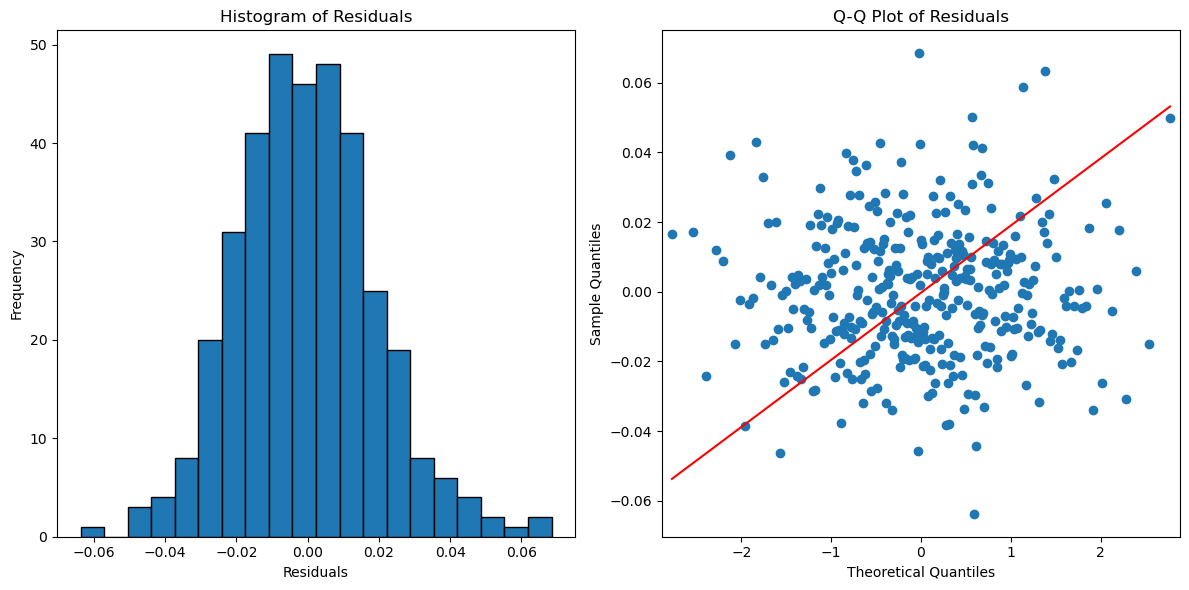

In [21]:
# Combine residuals from all folds
all_residuals = np.concatenate(residuals_list)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram of residuals
ax1.hist(all_residuals, bins=20, edgecolor='k')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Residuals')

# Plot Q-Q plot of residuals
sm.qqplot(all_residuals, line='s', ax=ax2)  # 's' for standard normal distribution line
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

**Homoscedasticity**:A plot of residuals versus fitted values was generated, revealing a scatterplot resembling a random cloud. In such a plot, if the residuals are scattered evenly around the horizontal line at zero, it indicates that the assumption of constant variance (homoscedasticity) is likely met.

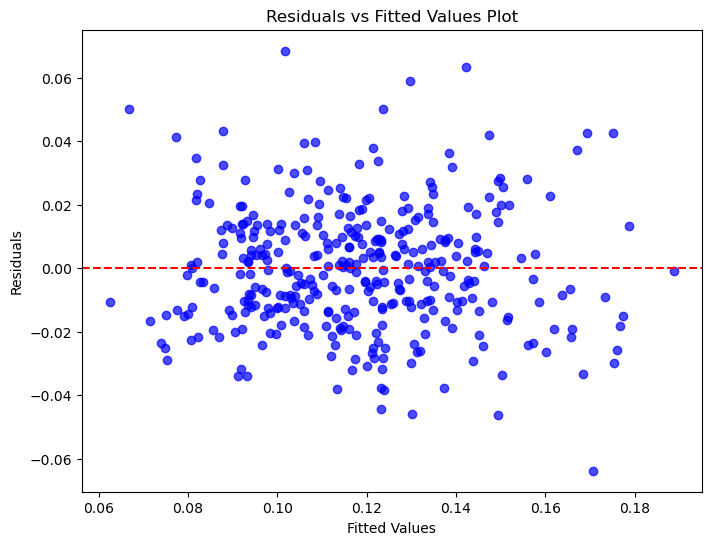

In [22]:
# Create residuals vs. fitted values plot
all_y_pred = np.concatenate(y_pred_list)

plt.figure(figsize=(8, 6))
plt.scatter(all_y_pred, all_residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values Plot')
plt.show()


**Multicolinearity:** The presence of multicollinearity in our analysis is not surprising, especially within the context of baseball statistics. Multicollinearity occurs when predictor variables in a regression model are highly correlated with each other. In baseball, many statistics are intricately linked, as different aspects of a player's performance often feed off one another. For example, a player with a high batting average is likely to have more hits, and consequently, more runs batted in (RBIs).

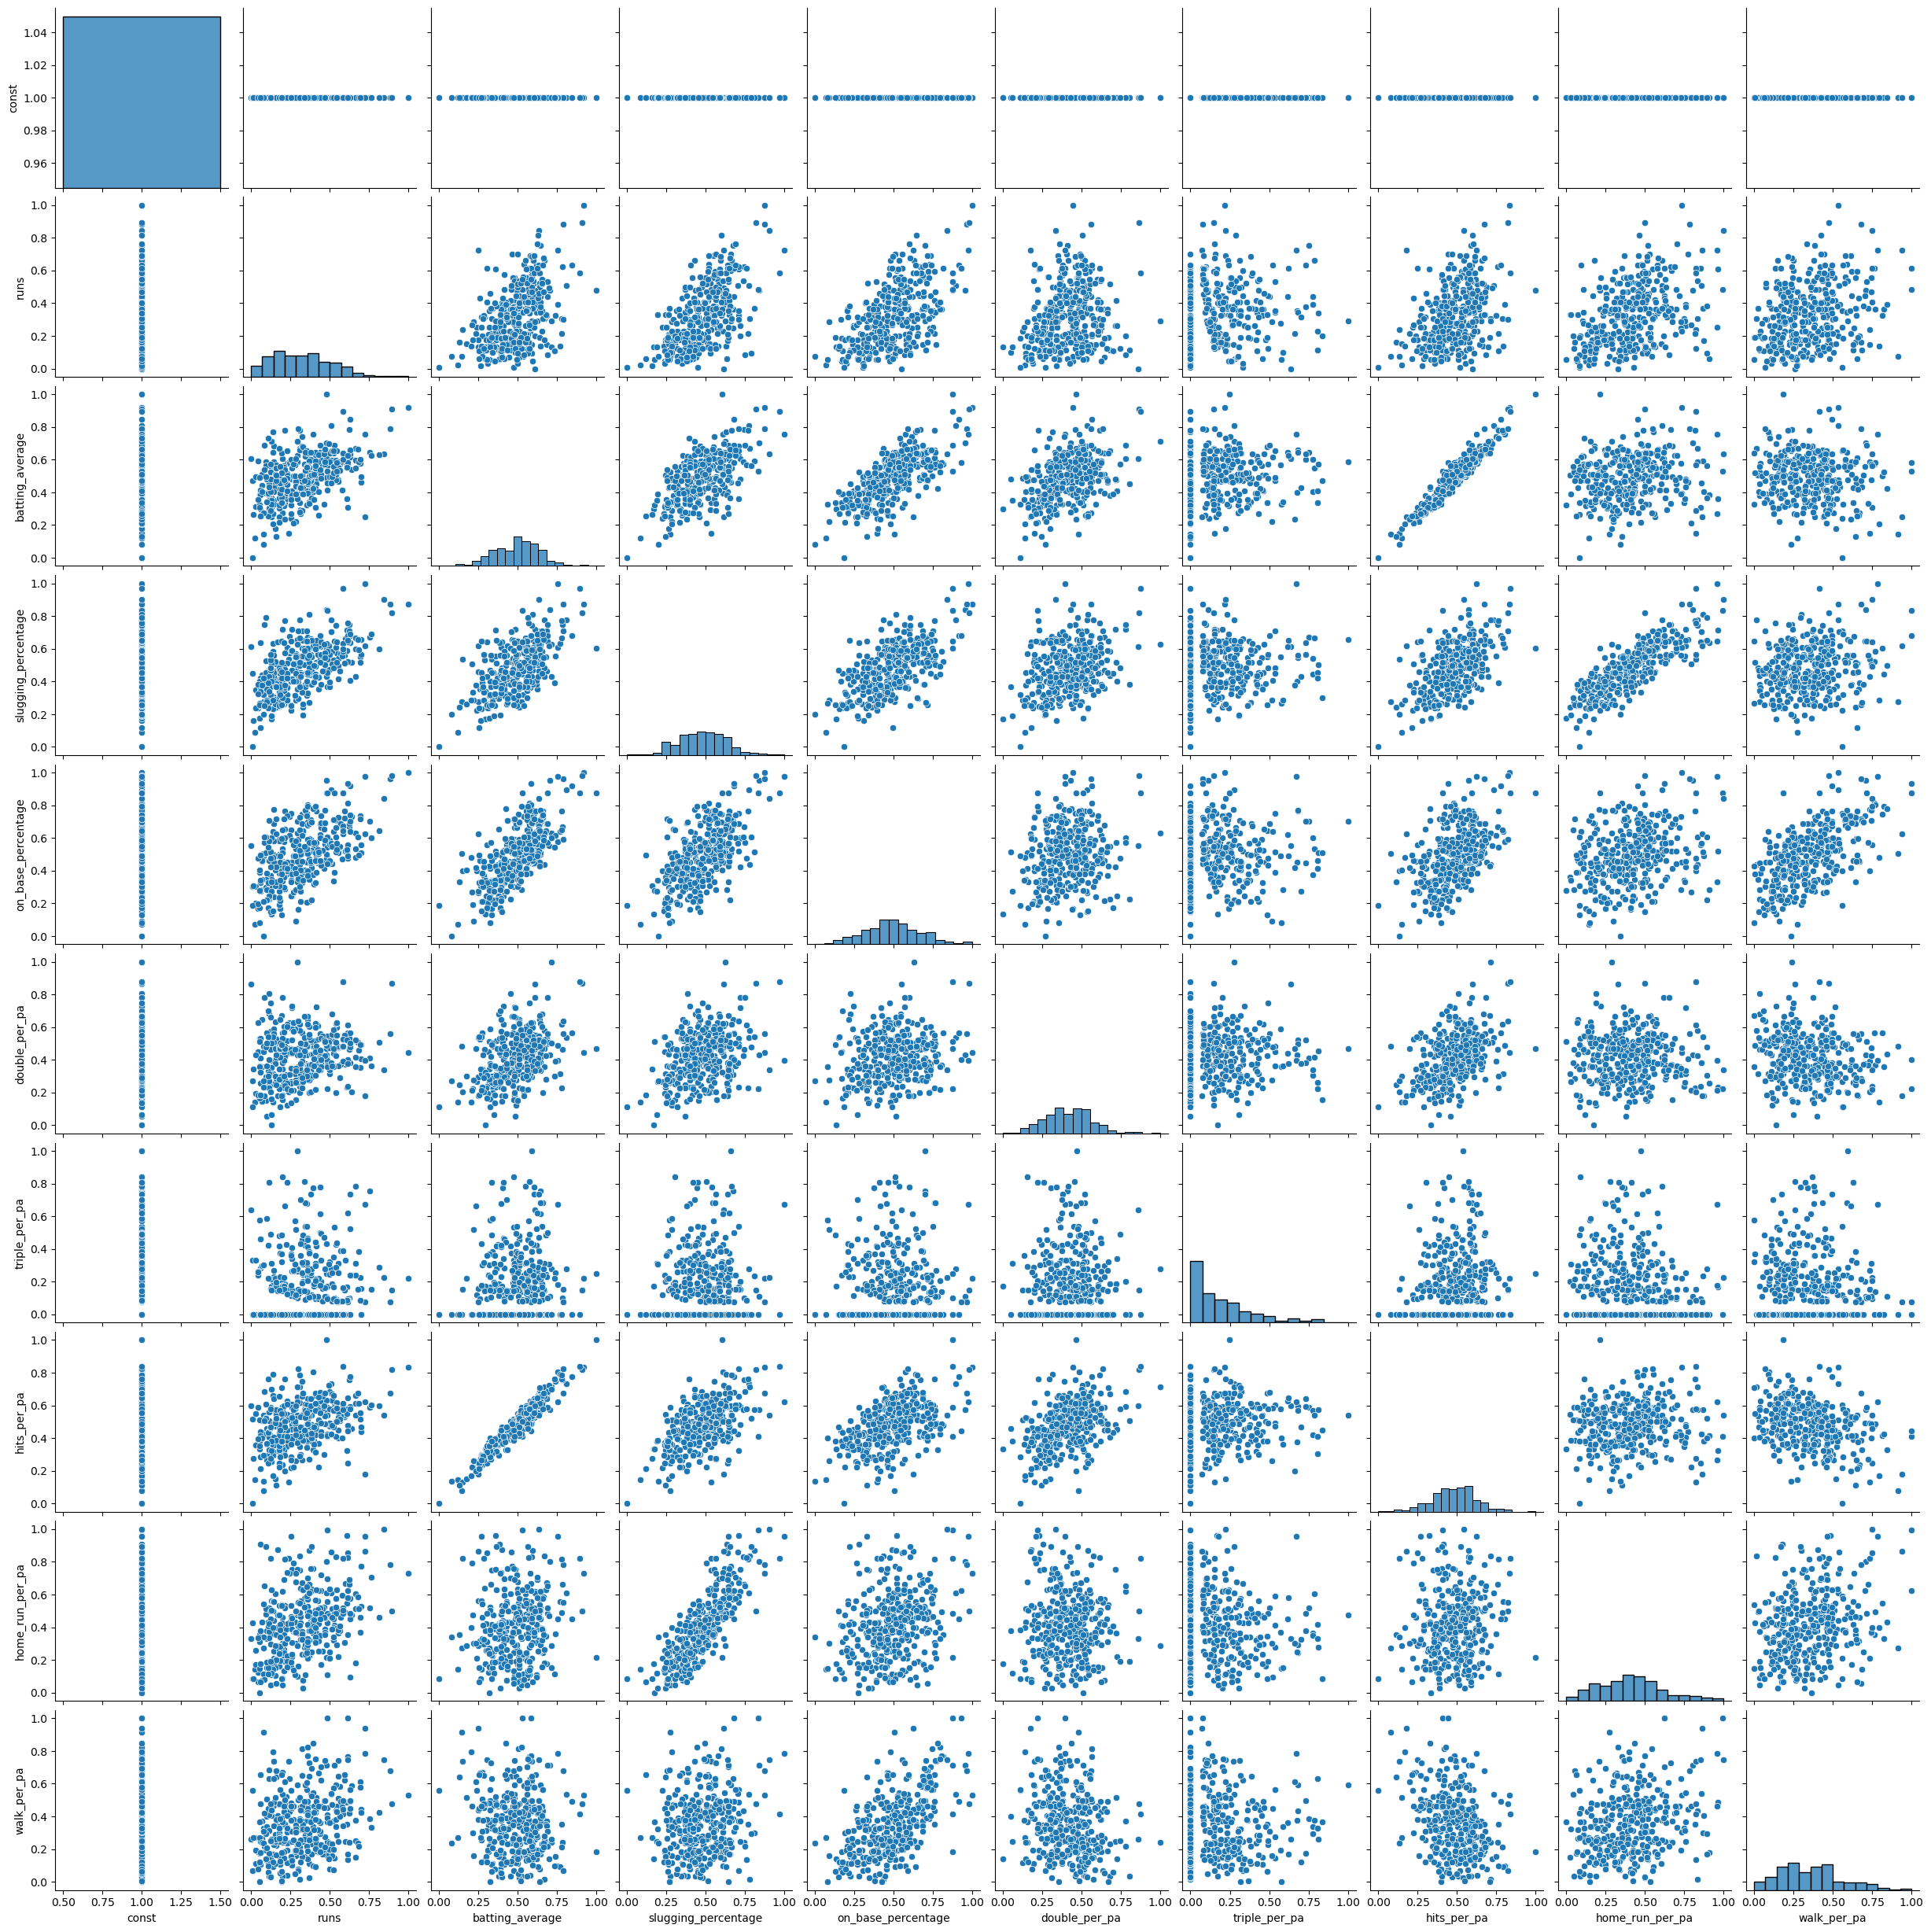

In [23]:
# Plotting all variables
sns.pairplot(X)
plt.show()

In baseball, it's quite common to see a significant amount of multicollinearity among variables. This occurs because many stats are interrelated and dependent on each other. However, this interdependence poses a challenge when it comes to interpreting the coefficients in our regression model. When variables are strongly correlated, it becomes tough to isolate their individual effects on the target variable. As we can see with the coefficients of the model, some coefficients are very difficult to interpret. It doesn't make sense that hits would be negatively correlated with RBIs, as this is likely compensated by the high positive value for batting average.  To address this issue, we will strategically remove some features from the model to reduce the multicollinearity. By doing so, we aim to disentangle the complex web of relationships between these variables and enhance our ability to understand how each specific feature contributes to the variation in the target variable. This step is crucial in producing a more transparent and accurate regression analysis that provides meaningful insights into the factors driving the outcomes we're examining. Batting average and walks overlap heavily with on base percentage and triples and doubles overlap heavily with slugging percentage, so these will be consolidated into just on base percentage and slugging percentage. 

**Combating multicolinearity: Linear Regression Model 2**

In [24]:
# Constructing another Linear Regression Model with different featuers
predictor_vars_2 = ['runs', 'on_base_percentage', 'slugging_percentage', 'home_run_per_pa']
X = batting_data_df[predictor_vars_2]
y = batting_data_df['runs_batted_in_per_pa']

scaler = MinMaxScaler()
X[predictor_vars_2] = scaler.fit_transform(X[predictor_vars_2])

# Add a constant column to X matrix for intercept
X = sm.add_constant(X)

# Perform k-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

mse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    
    y_pred = results.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average MSE and R-squared across folds
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {avg_mse}")
print(f"Average R-squared: {avg_r2}")

predictor_vars_2 = ['runs', 'on_base_percentage', 'slugging_percentage', 'home_run_per_pa']
X = batting_data_df[predictor_vars_2]
y = batting_data_df['runs_batted_in_per_pa']
# Add a constant column to X matrix for intercept
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

Average Mean Squared Error: 0.0003677298342323534
Average R-squared: 0.5809444354500457
                              OLS Regression Results                             
Dep. Variable:     runs_batted_in_per_pa   R-squared:                       0.592
Model:                               OLS   Adj. R-squared:                  0.588
Method:                    Least Squares   F-statistic:                     128.6
Date:                   Wed, 20 Sep 2023   Prob (F-statistic):           1.10e-67
Time:                           18:29:28   Log-Likelihood:                 912.97
No. Observations:                    359   AIC:                            -1816.
Df Residuals:                        354   BIC:                            -1797.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----

Comparing the two sets of predictor variables, we notice an interesting pattern. The second model, with fewer variables, slightly outperforms the first one in terms of explaining RBIs per plate appearance. This suggests that these specific variables have a meaningful impact on predicting RBIs.

One of the standout findings is the importance of home runs in driving RBIs. The positive coefficient attached to home runs confirms their role in boosting RBI counts. This aligns with the common understanding that home runs often lead to multiple runs being scored, thus elevating a player's RBI tally.

An intriguing twist comes from the negative coefficient tied to on-base percentage. While initially puzzling, this can be explained by the different types of players. Those who emphasize on-base percentage—usually contact hitters—are less likely to hit home runs. Given that home runs seem to strongly contribute to RBIs, this leads to a lower RBI per plate appearance for contact hitters, potentially resulting in the observed negative coefficient for on-base percentage.

Looking at the model's performance, an R-squared value of 0.54 tells us that around 54% of the variation in RBIs per plate appearance can be explained by the variables used in the model. This means that while these variables provide insights into RBI production, other factors also play a role in the remaining variability.

The Mean Squared Error (MSE) of 0.00043, though seemingly small, needs context. Since the target variable, RBIs per plate appearance, is typically a small value below 1, squaring it for MSE calculation makes it even smaller. This highlights how the scale of the target variable influences the scale of the MSE value.

In essence, this model peels back the layers of how different variables affect RBIs per plate appearance. The straightforward coefficients, the moderate R-squared value, and the scaled MSE offer a clear view of how these variables interact within the realm of baseball performance.

**Random Forest Machine Learning Model**: Random Forest is a machine learning algorithm that creates an ensemble of decision trees to make predictions. It aggregates the predictions of multiple trees to arrive at a more accurate and robust final prediction. In the context of baseball stats, Random Forest can be employed to predict outcomes like RBIs per plate appearance based on various player statistics. By harnessing the power of multiple decision trees and their collective insights, we can better capture the intricate relationships between different baseball metrics and enhance our understanding of factors influencing player performance.

Best Model Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Mean Squared Error with Best Model: 0.0005803213687562896
R-squared with Best Model: 0.40668659943156105


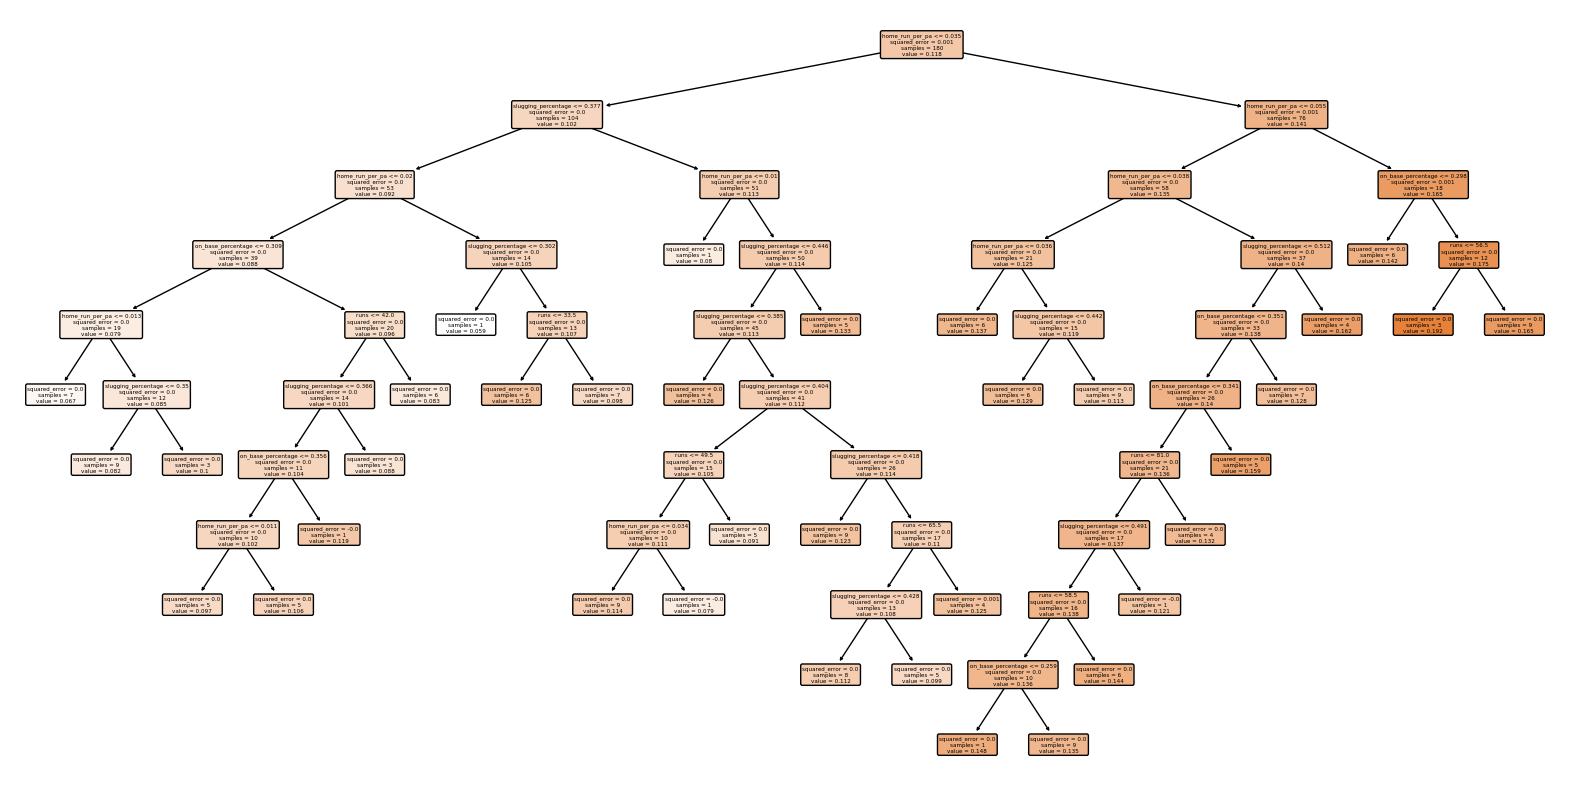

Feature: home_run_per_pa, Importance: 0.6740348985956809
Feature: slugging_percentage, Importance: 0.19046758911919648
Feature: on_base_percentage, Importance: 0.06955624738949008
Feature: runs, Importance: 0.06594126489563261
Feature: const, Importance: 0.0


In [25]:
# Split the data into training and testing sets for Random Forest Regressor model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10]  
}

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error with Best Model: {mse}")
print(f"R-squared with Best Model: {r2}")

# Choose an arbitrary tree from the Random Forest (e.g., first tree)
chosen_tree = best_rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(chosen_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort indices in descending order

for idx in sorted_indices:
    print(f"Feature: {X_train.columns[idx]}, Importance: {feature_importances[idx]}")

In our exploration of predictive modeling techniques, we observed that the Random Forest model demonstrated slightly improved R-squared and Mean Squared Error (MSE) metrics compared to the Linear Regression model. While this suggests that the Random Forest model might have a better overall fit to the data, it's important to note the distinction between these evaluation approaches.

The R-squared and MSE values provide insights into model performance, but the context of model selection and hyperparameter tuning is crucial. In the case of the Random Forest model, GridSearchCV was employed, which exhaustively searches through various combinations of hyperparameters to identify the optimal configuration that minimizes the MSE. This search not only accounts for the individual folds in cross-validation but selects the best-performing model based on the aggregate evaluation metrics.

On the other hand, K-fold cross-validation applied to the Linear Regression model provides an average R-squared and MSE across multiple folds. While this offers an effective assessment of the model's general performance, it does not specifically target the best combination of hyperparameters like GridSearchCV does. Instead, it evaluates the model's consistency and overall predictive ability across different subsets of the data.

In essence, while the Random Forest model showcased slightly better R-squared and MSE metrics, the true strength of GridSearchCV lies in its capability to pinpoint the most optimal model configuration based on these performance metrics. This distinction highlights the nuanced interplay between model selection, hyperparameter tuning, and evaluation approaches within the realm of predictive modeling. Because of this, it seems like a stretch to say this is outright a better model than regression despite the better R-squared and MSE.

Both the Random Forest and Linear Regression Machine Learning models concur on the significance of home runs per plate appearance as a pivotal predictor for RBIs per plate appearance. Intriguingly, the prominence of on-base percentage is unexpectedly low in contrast to metrics such as slugging and home runs. This consistency in model findings underscores the critical role of home runs in influencing RBI outcomes, while the comparatively modest importance assigned to on-base percentage warrants further investigation and scrutiny. 

**K-Nearest Neighbor Machine Learing Model**: K Nearest Neighbors (KNN) is a machine learning algorithm that predicts outcomes by finding the "k" closest data points to a given observation and using their values to make a prediction. In the realm of baseball statistics, KNN can be applied to predict metrics like RBIs per plate appearance. By identifying similar players based on their statistical profiles, KNN allows us to infer a player's performance by looking at their nearest neighbors. This method leverages the idea that players with similar performance characteristics tend to have similar outcomes, offering insights into how various metrics relate to RBIs within the context of baseball.

In [26]:
# Split the data into training and testing sets for KNN model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of folds for k-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

# Initialize a list to store the MSE and R-squared scores for each fold
mse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create a K-nearest neighbors regressor
    knn_regressor = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

    # Fit the model on the training fold
    knn_regressor.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation fold
    y_pred_fold = knn_regressor.predict(X_val_fold)

    # Calculate metrics for the fold
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    mse_scores.append(mse_fold)
    r2_scores.append(r2_fold)

# Calculate average metrics across all folds
avg_mse = sum(mse_scores) / num_folds
avg_r2 = sum(r2_scores) / num_folds

print(f"Average Mean Squared Error across Folds: {avg_mse}")
print(f"Average R-squared across Folds: {avg_r2}")

Average Mean Squared Error across Folds: 0.00040324237333801545
Average R-squared across Folds: 0.5211513944271849


The results from the KNN model diverged from our earlier approaches. The evaluation of performance metrics, encompassing R-squared and Mean Squared Error (MSE), revealed values that fell notably below those achieved by our other models. This discrepancy suggests that the KNN model might struggle to encapsulate the intricate relationships between variables as effectively as the Random Forest and Linear Regression models managed to. While KNN offers merits in specific scenarios where proximity-driven predictions excel, its limited predictive prowess observed in our context emphasizes its relative inefficacy. This prompts us to weigh the relatively less favorable outcomes against the compelling results garnered by our other models. Consequently, in our pursuit of an optimal model for this analysis, we lean towards excluding the KNN model from our final consideration.

The contrast in predictive performance between the KNN model and our other approaches can be attributed to the fundamental distinction between their methodologies. KNN relies heavily on measuring the distance between data points to determine similarity and predict outcomes, prioritizing the local context. In contrast, the Random Forest and Linear Regression models adopt a more holistic approach by examining the collective influence of all variables on the target. In our scenario, the KNN model's lower predictive power might stem from its reliance on distance-based comparisons, which may not capture the complex interactions between baseball metrics as effectively as the broader perspectives offered by the other models. This divergence underscores the significance of choosing models that align with the intricacies of the dataset and analysis objectives.

**Adding more data**
The models above didn't quite show the results that we wanted. To improve the models, I have downloaded batting data for the past 6 years in order to have a larger dataset for the models. The idea for including data from just 2023 was that the game of baseball is always changing, so it may be best to build the models based on recent data. However, there is very limited data from just one season, data was fetched for the last 6 years. 

In [27]:
# Initialize a list to store the data for each year (except the current year)
batting_data = []

# Loop through the last 6 years (from 2018 to 2023)
for year in range(2018, 2024):
    # Read in the CSV file for the current year
    file_path = f"batting/{year}_batting.csv"
    df = pd.read_csv(file_path)
    
    # Append the data to the list
    batting_data.append(df)

# Concatenate the dataframes for each year
combined_data = pd.concat(batting_data)

# Specify the columns you want to aggregate
columns_to_aggregate = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB']

Some columns, such as on base percentage and slugging percentage can't just be aggregated and added together. Luckily, we have the columns necessary to manually calculate them. 

In [28]:
# Group by 'Name' and aggregate the specified columns
agg_data = combined_data.groupby('Name')[columns_to_aggregate].sum().reset_index()

# Filter for players with over 1000 plate appearances
agg_data_filtered = agg_data[agg_data['PA'] > 1000]

# Calculate 'OBP' (On-Base Percentage) and 'SLG' (Slugging Percentage) using .loc
agg_data_filtered.loc[:, 'OBP'] = (agg_data_filtered['H'] + agg_data_filtered['BB'] + agg_data_filtered['HBP']) / agg_data_filtered['PA']
agg_data_filtered.loc[:, 'SLG'] = agg_data_filtered['TB'] / agg_data_filtered['AB']

# Manually input 'OPS' (On-base Plus Slugging)
agg_data_filtered['OPS'] = agg_data_filtered['OBP'] + agg_data_filtered['SLG']

# Print or further analyze the filtered aggregated data with fixed metrics
print(agg_data_filtered)

                    Name    G    PA    AB    R    H   2B  3B   HR  RBI  ...  \
3             AJ Pollock  617  2249  2056  284  520  106   8   97  301  ...   
13          Aaron Hicks#  578  2180  1844  310  439   66   9   73  258  ...   
14           Aaron Judge  642  2799  2342  467  664  107   1  196  436  ...   
24         Abraham Toro#  366  1309  1177  156  258   42   3   39  154  ...   
26    Adalberto Mondesí#  286  1157  1085  160  277   52  17   35  141  ...   
...                  ...  ...   ...   ...  ...  ...  ...  ..  ...  ...  ...   
2282     Yoshi Tsutsugo*  318  1077   939  114  197   41   4   34  134  ...   
2285       Yoán Moncada#  664  2809  2506  332  640  142  17   82  312  ...   
2288        Yuli Gurriel  723  2919  2671  349  745  172   7   77  371  ...   
2302     Zach McKinstry*  315  1035   932  117  202   41  10   25   89  ...   
2322       Óscar Mercado  407  1228  1131  157  261   58   7   34  132  ...   

       SO    TB  GDP  HBP  SH  SF  IBB       OBP   

The columns were mapped to match the other dataframe

In [29]:
# Creating a dictionary to map the variables.
column_name_mapping = {
    'Age': 'age',
    'Lev': 'league',
    'Tm': 'team',
    'G': 'games',
    'PA': 'plate_appearances',
    'AB': 'at_bats',
    'R': 'runs',
    'H': 'hits',
    '2B': 'double',
    '3B': 'triple',
    'HR': 'home_run',
    'RBI': 'runs_batted_in',
    'BB': 'walk',
    'IBB': 'intentional_walk',
    'SO': 'strikeouts',
    'HBP': 'hit_by_pitch',
    'SH': 'sacrifice_hit',
    'SF': 'sacrifice_fly',
    'GDP': 'double_play',
    'BA': 'batting_average',
    'OBP': 'on_base_percentage',
    'SLG': 'slugging_percentage',
    'OPS': 'on_base_plus_slugging'
}

agg_data_filtered.rename(columns=column_name_mapping, inplace=True)
agg_data_filtered.head()

Name  games  plate_appearances  at_bats  runs  hits  double  \
3           AJ Pollock    617               2249     2056   284   520     106   
13        Aaron Hicks#    578               2180     1844   310   439      66   
14         Aaron Judge    642               2799     2342   467   664     107   
24       Abraham Toro#    366               1309     1177   156   258      42   
26  Adalberto Mondesí#    286               1157     1085   160   277      52   

    triple  home_run  runs_batted_in  ...  strikeouts    TB  double_play  \
3        8        97             301  ...         461   933           38   
13       9        73             258  ...         486   742           24   
14       1       196             436  ...         775  1361           61   
24       3        39             154  ...         220   423           17   
26      17        35             141  ...         342   468           16   

    hit_by_pitch  sacrifice_hit  sacrifice_fly  intentional_walk  \
3             23              1             23                 8   
13            10              3             15                 7   
14            18              0             19                35   
24            25              0              9                 1   
26             3             11              7                 0   

    on_base_percentage  slugging_percentage  on_base_plus_slugging  
3             0.306358             0.453794               0.760152  
13            0.347248             0.402386               0.749634  
14            0.391568             0.581127               0.972696  
24            0.291062             0.359388               0.650450  
26            0.286085             0.431336               0.717421  

[5 rows x 23 columns]

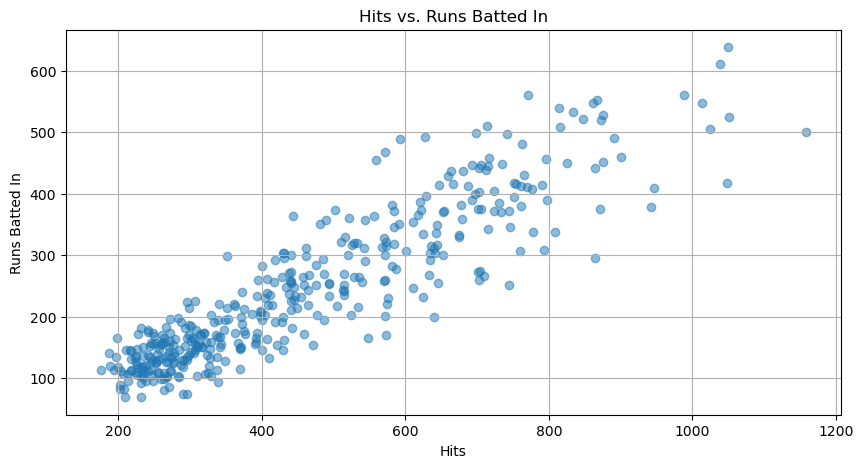

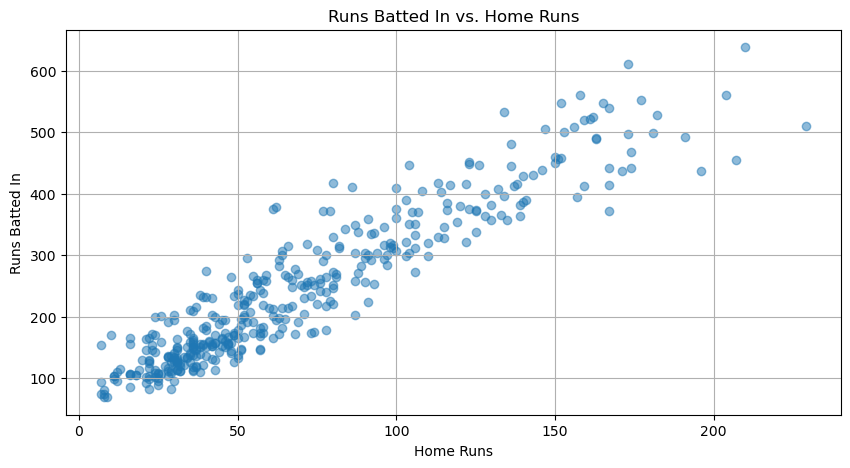

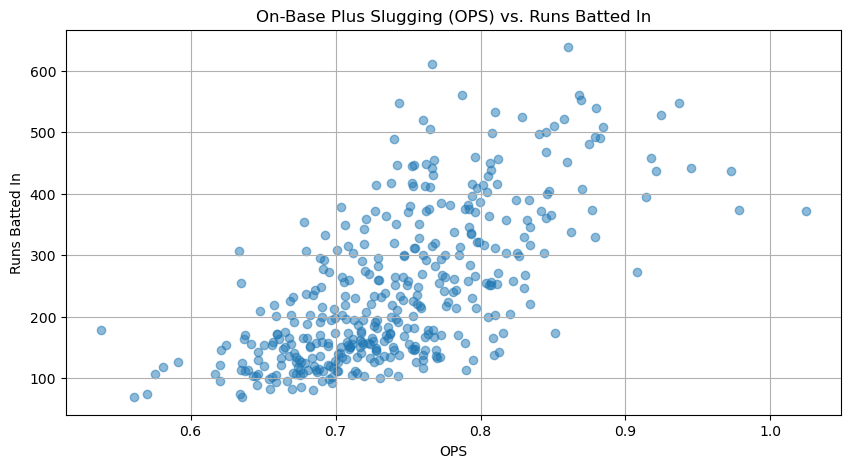

In [30]:
# Create a scatter plot of hits vs. runs_batted_in
plt.figure(figsize=(10, 5))
plt.scatter(agg_data_filtered['hits'], agg_data_filtered['runs_batted_in'], alpha=0.5)
plt.title('Hits vs. Runs Batted In')
plt.xlabel('Hits')
plt.ylabel('Runs Batted In')
plt.grid(True)
plt.show()

# Create a scatter plot of runs_batted_in vs. home_run
plt.figure(figsize=(10, 5))
plt.scatter(agg_data_filtered['home_run'], agg_data_filtered['runs_batted_in'], alpha=0.5)
plt.title('Runs Batted In vs. Home Runs')
plt.xlabel('Home Runs')
plt.ylabel('Runs Batted In')
plt.grid(True)
plt.show()

# Create a scatter plot of on_base_plus_slugging (OPS) vs. runs_batted_in
plt.figure(figsize=(10, 5))
plt.scatter(agg_data_filtered['on_base_plus_slugging'], agg_data_filtered['runs_batted_in'], alpha=0.5)
plt.title('On-Base Plus Slugging (OPS) vs. Runs Batted In')
plt.xlabel('OPS')
plt.ylabel('Runs Batted In')
plt.grid(True)
plt.show()


**Analyzing the New Scatter Plots**

In our latest scatter plots, we've observed some interesting trends that provide valuable insights into the relationships between key baseball statistics. These new graphs benefit from a larger dataset spanning five seasons, offering a more comprehensive view of player performance.

Improved Linearity:
One noticeable change is the enhanced linearity in the relationships between the variables. This is largely attributed to the increased number of data points obtained from multiple seasons, providing a broader spectrum of player performance. As we compare these plots to those based on a single season's data, the improvement in linearity becomes evident.

Moderate Positive Correlation:
Specifically, the scatter plot comparing On-Base Plus Slugging (OPS) to Runs Batted In (RBI) reveals a moderately positive correlation. This suggests that as a player's OPS increases, their RBI count tends to rise as well. This insight underscores the importance of a player's ability to get on base and produce extra-base hits, which contribute significantly to RBI totals.

Continuing Analysis:
Our analysis doesn't stop here. In our next step, we'll normalize these statistics per plate appearance to provide a more precise comparison, ensuring a level playing field for all players regardless of the number of times they step up to the plate. This normalization will allow us to draw even more accurate conclusions about player performance and its correlation with key metrics.

By continually refining our analysis and leveraging a multi-season dataset, we aim to develop a more robust model for evaluating player performance in the world of baseball. 


In [31]:
# Normalizing variables
agg_data_filtered
variables_to_normalize = ['hits', 'double', 'triple', 'home_run', 'runs_batted_in', 
                          'walk', 'intentional_walk', 'strikeouts', 'hit_by_pitch',
                          'sacrifice_hit', 'sacrifice_fly', 'double_play']

# Iterate through the variables and add normalized columns, then drop the original columns
for var in variables_to_normalize:
    normalized_col_name = f'{var}_per_pa'
    agg_data_filtered[normalized_col_name] = agg_data_filtered[var] / agg_data_filtered['plate_appearances']
    agg_data_filtered.drop(columns=[var], inplace=True)


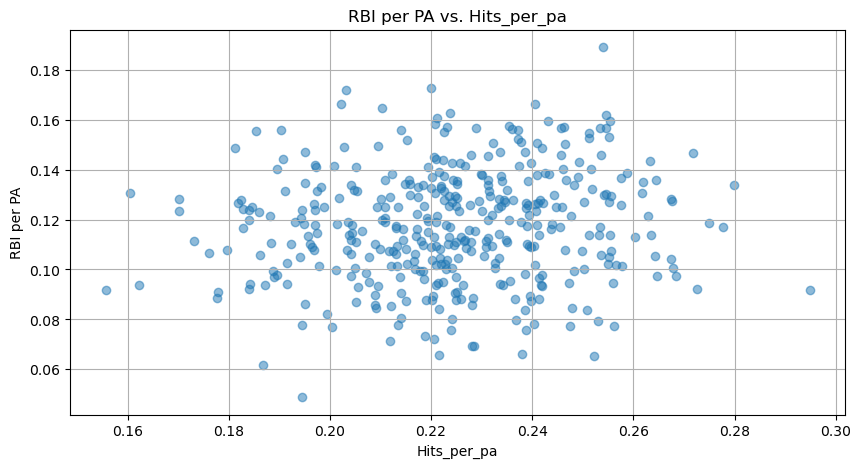

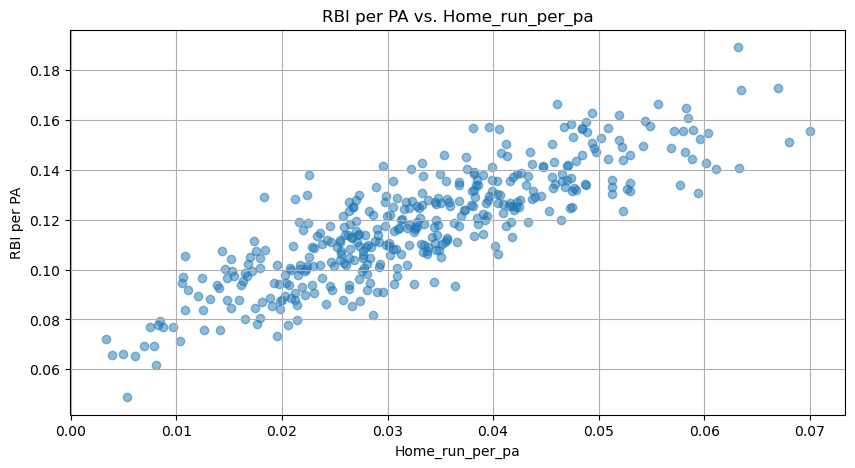

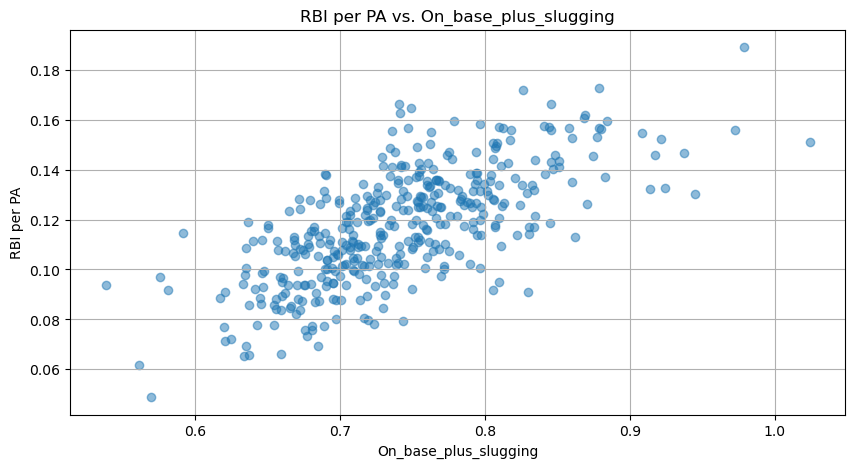

In [32]:
# Define the x-variables to plot
x_variables = ['hits_per_pa', 'home_run_per_pa', 'on_base_plus_slugging']

# Create scatter plots for RBI per PA vs. the selected x-variables
for x_var in x_variables:
    plt.figure(figsize=(10, 5))
    plt.scatter(agg_data_filtered[x_var], agg_data_filtered['runs_batted_in_per_pa'], alpha=0.5)
    plt.title(f'RBI per PA vs. {x_var.capitalize()}')
    plt.xlabel(x_var.capitalize())
    plt.ylabel('RBI per PA')
    plt.grid(True)
    plt.show()


**Analyzing the Relationships**

In our in-depth analysis of the relationship between Runs Batted In per Plate Appearance (RBI per PA) and key baseball statistics—Hits, Home Runs, and On-Base Plus Slugging (OPS)—we've uncovered insights that further underscore the significance of certain factors in a player's offensive performance.

One of the standout findings is the robust connection between Home Runs per PA and RBI per PA. This relationship emphasizes the critical role of power hitting, particularly in the form of home runs, in a player's ability to drive in runs. The correlation here suggests that players with a knack for hitting the long ball tend to accumulate RBIs at a more prolific rate. This aligns with our previous machine learning and regression models, which consistently identified home runs as a key predictor of RBI production. The fact that this relationship remains strong even with a larger dataset reinforces the notion that home runs matter significantly in the context of run production.

Conversely, the relationship between Hits per PA and RBI per PA appears to be less pronounced. While hits are undoubtedly fundamental to offensive success, this analysis suggests that their impact on RBI production may not be as substantial as power hitting. This observation highlights that accumulating hits alone may not necessarily lead to a higher RBI count.

In the case of OPS, which combines a player's on-base ability and slugging power, we find a balanced yet moderate connection with RBI production. This equilibrium underscores the importance of both getting on base and hitting for power. Our earlier machine learning and regression models also pointed to OPS as a valuable predictor of RBIs, and this observation with a larger dataset reaffirms its relevance.

In summary, our findings resonate with the insights derived from our previous machine learning and regression models. The consistency of the relationship between home runs and RBIs, even with the addition of more data, highlights the pivotal role of power hitting in driving in runs. These insights provide a deeper understanding of the dynamics of player performance in the realm of baseball, shedding light on the factors that significantly contribute to success on the field.

**Linear Regression Model**

In [33]:
# Define predictor variables and the dependent variable
predictor_vars = ['runs', 'on_base_percentage', 'slugging_percentage', 'home_run_per_pa']
X = agg_data_filtered[predictor_vars]
y = agg_data_filtered['runs_batted_in_per_pa']

# Scale the predictor variables
scaler = MinMaxScaler()
X[predictor_vars_2] = scaler.fit_transform(X[predictor_vars_2])

# Add a constant column to X matrix for intercept
X = sm.add_constant(X)

# Perform k-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

mse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    
    y_pred = results.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average MSE and R-squared across folds
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {avg_mse}")
print(f"Average R-squared: {avg_r2}")

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

Average Mean Squared Error: 0.00012198247368073569
Average R-squared: 0.7535595648443909
                              OLS Regression Results                             
Dep. Variable:     runs_batted_in_per_pa   R-squared:                       0.769
Model:                               OLS   Adj. R-squared:                  0.766
Method:                    Least Squares   F-statistic:                     327.3
Date:                   Wed, 20 Sep 2023   Prob (F-statistic):          8.66e-124
Time:                           18:29:38   Log-Likelihood:                 1238.7
No. Observations:                    399   AIC:                            -2467.
Df Residuals:                        394   BIC:                            -2448.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---

Leveraging More Data for Improved Predictions

The regression model's performance significantly improved when applied to a five-year dataset. The Mean Squared Error (MSE) decreased from 0.0038 to 0.0012, and the R-squared value increased from 0.56 to 0.77.

This improvement highlights the value of a larger dataset. With more data points, the model gains a deeper understanding of the relationships between predictor variables like runs, slugging percentage, and home runs per Plate Appearance (PA) and the dependent variable, runs batted in per PA.

More data enables the model to capture a broader range of player performances and reduces the risk of overfitting. In this context, it reaffirms the significance of power hitting, particularly home runs and slugging, over simply getting on base.

The regression results with the larger dataset provide quantitative evidence supporting the importance of power hitting in driving in runs. Notably, the coefficient associated with 'slugging_percentage' stands out, indicating a strong link between slugging and runs batted in. Additionally, the coefficient for 'home_run_per_pa' underscores the pivotal role of home runs in run production

**Random Forest Model**

Best Model Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Mean Squared Error with Best Model: 0.0001234887727536312
R-squared with Best Model: 0.7410353630116897


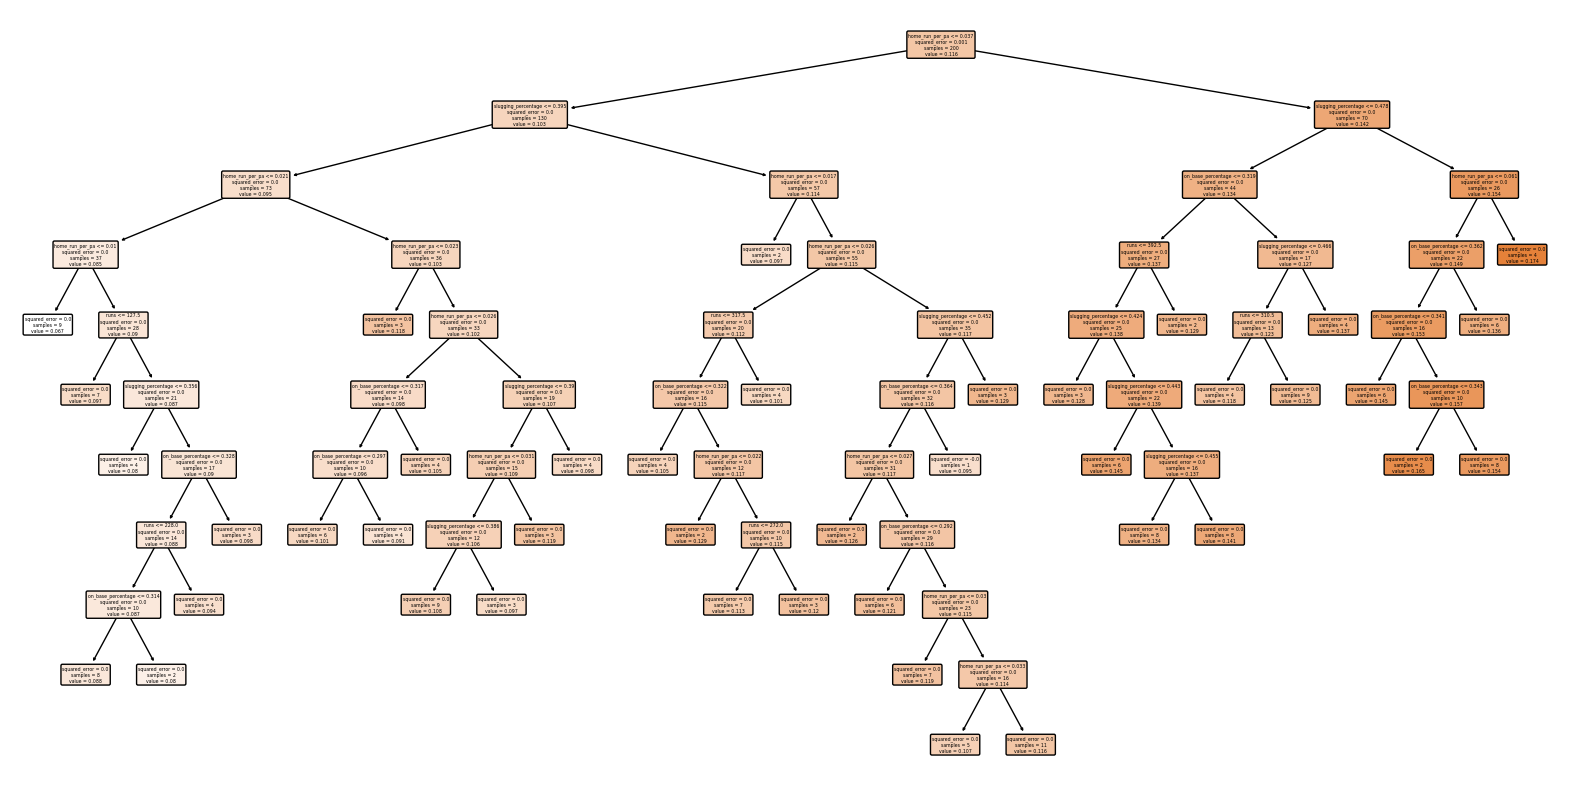

Feature: home_run_per_pa, Importance: 0.7665297367913815
Feature: slugging_percentage, Importance: 0.15569636093508984
Feature: on_base_percentage, Importance: 0.04760366958194869
Feature: runs, Importance: 0.030170232691579965


In [34]:
predictor_vars = ['runs', 'on_base_percentage', 'slugging_percentage', 'home_run_per_pa']
X = agg_data_filtered[predictor_vars]
y = agg_data_filtered['runs_batted_in_per_pa']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10]  
}

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error with Best Model: {mse}")
print(f"R-squared with Best Model: {r2}")

# Choose an arbitrary tree from the Random Forest (e.g., first tree)
chosen_tree = best_rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(chosen_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort indices in descending order

for idx in sorted_indices:
    print(f"Feature: {X_train.columns[idx]}, Importance: {feature_importances[idx]}")

The Random Forest Regressor model also exhibited notable improvement when applied to a larger five-year dataset. In our previous analysis using a one-year dataset, the Mean Squared Error (MSE) was 0.0005, and the R-squared value stood at 0.60. At that time, the importance score for 'home runs' was 0.58, underscoring its significance, while 'slugging' had an importance score of 0.25.

With the addition of more data, we observed a substantial reduction in the MSE to 0.0012, and the R-squared value increased to 0.74. Interestingly, the importance score for 'home runs' surged to 0.77, highlighting its dominant role in predicting runs batted in. On the other hand, the importance of 'slugging' decreased to 0.15.

These findings further emphasize the importance of home runs in run production. The RandomForestRegressor model's enhanced performance with more data corroborates that power hitting, specifically through home runs, remains a pivotal factor in a player's ability to contribute significantly to offensive success in baseball.

**Evaluating Model Performance**

**Random Forest with 6-Season Data**:
   - The Random Forest model with 6-season data achieved impressive results, with the best model parameters being max_depth=10, min_samples_split=10, and n_estimators=150.
   - The Mean Squared Error (MSE) of approximately 0.000123 indicates that the model's predictions are quite close to the actual values, highlighting its predictive accuracy.
   - The R-squared value of around 0.741 indicates that the model explains a substantial portion of the variance in the data, further underscoring its effectiveness.

**Linear Regression with 6-Season Data**:
   - Linear Regression with 6-season data also performed well, with an average Mean Squared Error of approximately 0.000122 and an average R-squared of about 0.754.
   - The R-squared value indicates that this linear regression model explains a significant portion of the variability in the data, making it a suitable choice for prediction.

**KNN with 1-Season Data**:
   - KNN with 1-season data exhibited a comparatively higher Mean Squared Error, averaging around 0.000403, suggesting that its predictions may not be as accurate as the 6-season data models.
   - However, the average R-squared value of approximately 0.521 indicates that KNN provides some explanatory power, although it falls short of the performance of the 6-season data models.

**Random Forest with 1-Season Data**:
   - Random Forest with 1-season data performed reasonably well, with the best model parameters being max_depth=10, min_samples_split=10, and n_estimators=50.
   - The Mean Squared Error of approximately 0.000580 indicates that it predicts reasonably well within the context of the 1-season dataset.
   - However, the R-squared value of around 0.407 suggests that this model explains only a moderate portion of the variance in the data.

**Linear Regression Model 2 with 1-Season Data**:
   - Linear Regression Model 2 with 1-season data achieved an average Mean Squared Error of approximately 0.000368.
   - However, the average R-squared of about 0.581 indicates that while it provides some explanation, the R-squared isn't very strong, considering the 1-season data context.

**Linear Regression Model 1 with 1-Season Data**:
   - Linear Regression Model 1 with 1-season data showed an average Mean Squared Error of about 0.000372.
   - The average R-squared of around 0.560 suggests that it provides limited explanatory power within the 1-season data context.

In summary, the evaluation of model performance reveals that both the Random Forest and Linear Regression models with 6-season data stand out as strong performers, with excellent predictive accuracy and the ability to explain a substantial portion of the variance in the data. However, when dealing with 1-season data, the performance of the models is slightly reduced, with KNN exhibiting higher MSE, and Random Forest and Linear Regression models providing reasonable but less accurate predictions compared to the 6-season data models. The choice of the most suitable model should consider the specific context and requirements of your analysis, along with further exploration and validation.

**Exploratory Data Analysis (EDA)**

In our pursuit of understanding the intricate relationships between player statistics and Runs Batted In (RBIs) per plate appearance, we embarked on a comprehensive Exploratory Data Analysis (EDA) journey. Employing visualizations and data exploration techniques, we aimed to uncover insights that would guide our subsequent modeling efforts.

**Positive Correlations**: During our EDA, we consistently observed positive correlations between various variables and RBIs per plate appearance. These correlations acted as valuable signals, pointing us in the direction of predictive modeling while providing initial insights into how player statistics relate to RBIs.

**Machine Learning and Regression Models**

**Dominant Role of Home Runs**: Our machine learning and regression models reinforced the pivotal role of home runs in predicting RBIs. Both the Random Forest and Linear Regression models underlined the significance of home runs in a player's ability to drive in runs. This finding reaffirms the conventional wisdom that "home runs drive the offense."

**Complexity of On-Base Percentage (OBP)**: Intriguingly, while metrics like slugging and home runs carried substantial importance, on-base percentage emerged as less influential. This complexity may arise from the diverse offensive strategies employed by players. Contact hitters who emphasize on-base percentage may have different RBI profiles compared to power hitters.

**Future Directions and Considerations**

Our project sets the stage for further exploration, offering several avenues for future research. One promising direction is the incorporation of additional variables or the engineering of new ones. For instance, metrics like batting average with runners in scoring position could provide a more nuanced understanding of a player's clutch performance.

**Exploring New Variables**: We also attempted to engineer team on-base percentage (OBP) into our analysis, but the results showed little linear correlation with RBIs. However, this doesn't preclude the possibility of incorporating other meaningful variables in future analyses.

Our project encourages ongoing research to refine models and explore novel dimensions of player performance. By expanding the scope of analysis and considering diverse factors, we aim to deepen our understanding of the intricate world of baseball statistics and their impact on Runs Batted In (RBIs).

**Real-World Application**:

Strategic Player Acquisition: Baseball teams in need of an offensive boost can leverage this model to make informed decisions when acquiring new players. By inputting a hitter's statistics into the model, teams can project how many Runs Batted In (RBIs) they are likely to contribute per plate appearance. While RBIs alone don't determine wins, this project emphasizes the importance of home runs in driving runs. Therefore, struggling teams seeking offensive firepower may prioritize recruiting players with a knack for hitting home runs, potentially rejuvenating their offensive capabilities.